In [ ]:
'''
check list

데이터
- mseed 기반
	포항 - 샘플링 200, label 존재
	STEAD - 샘플링 100, label 데이터 검색
- slice data 기반
	포항 - 랜덤 슬라이스
	STEAD - data generation

전처리
	정규화 - std, minmax
	labeling - smoothing, time field label
	hmm, snr

학습
	모델구조
	BCE
	class weight
	
후처리
	place plot
	overlap
	threshold
	csv 파일
'''

In [1]:
import numpy as np
import os
from tqdm.notebook import tqdm

data = dict()
data_path = os.path.join(os.getcwd(), 'data/BRIDGE')
file_list = os.listdir(data_path)

try:
    file_list.remove('.ipynb_checkpoints')
except:
    pass

for file in file_list:

    with open("./data/BRIDGE/" + file, 'r') as f:
        data[file] = dict()
#         excp = dict()

        raw_lines = f.read().splitlines() 

        for idx, line in tqdm(enumerate(raw_lines)):
            if idx == 0:
                columns = line.split(',')

                for col in columns:
                    data[file][col] = list()
#                     excp[col] = 0
            else:
                for jdx, col in enumerate(columns):
                    try:
                        data[file][col].append(float(line.split(',')[jdx]))
                    except:
                        data[file][col].append('nan')
#                         excp[col] += 1
            


file name :  GBB_20191231235000.txt



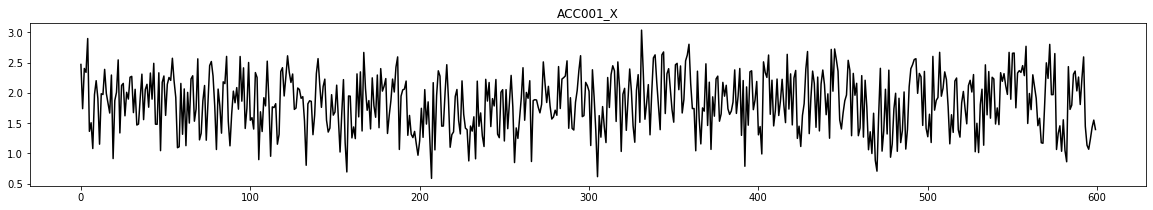

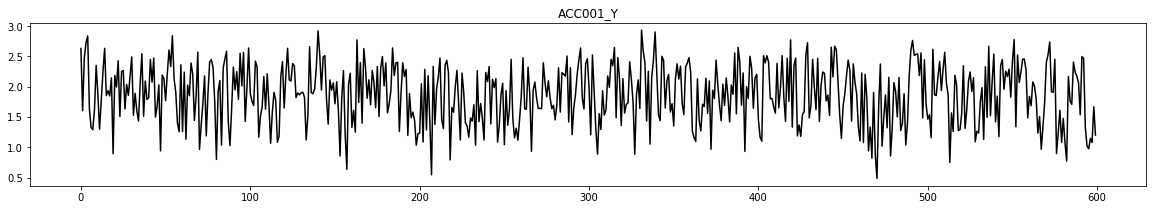

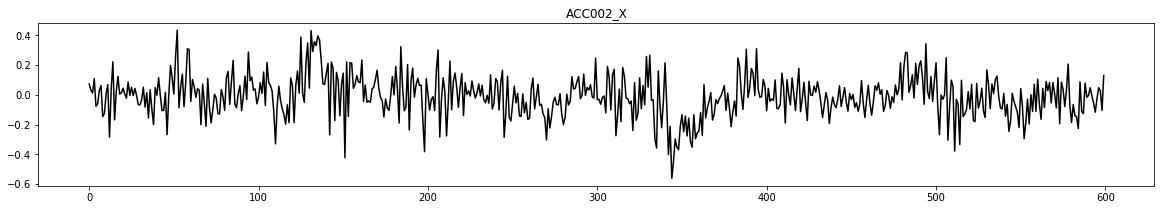

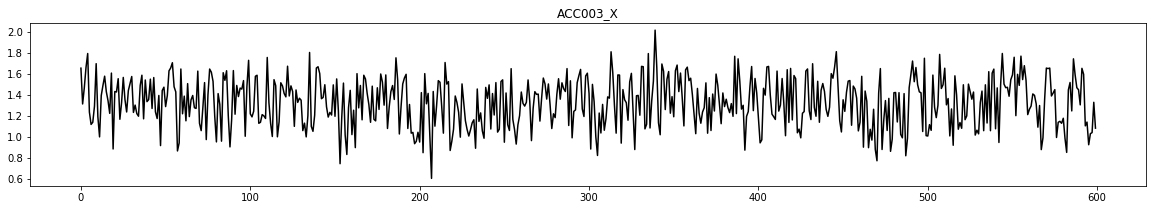

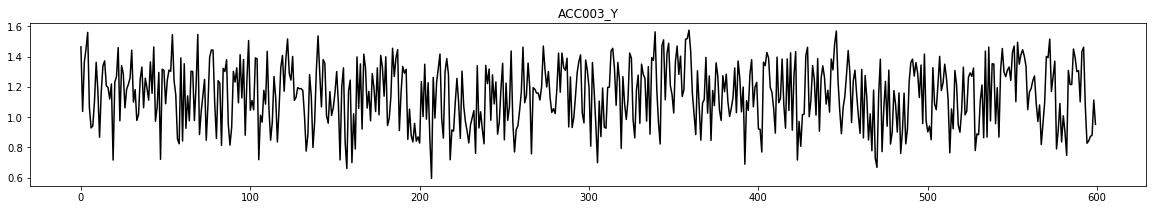

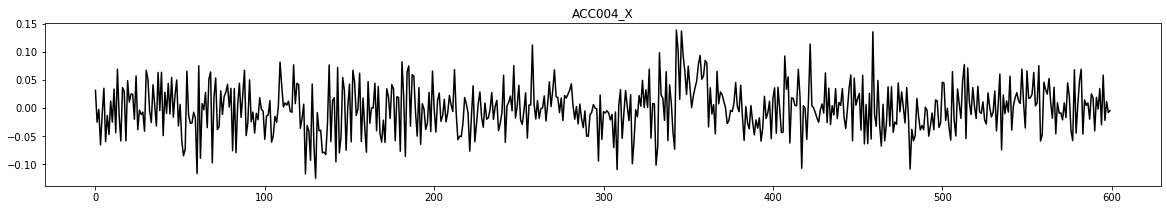

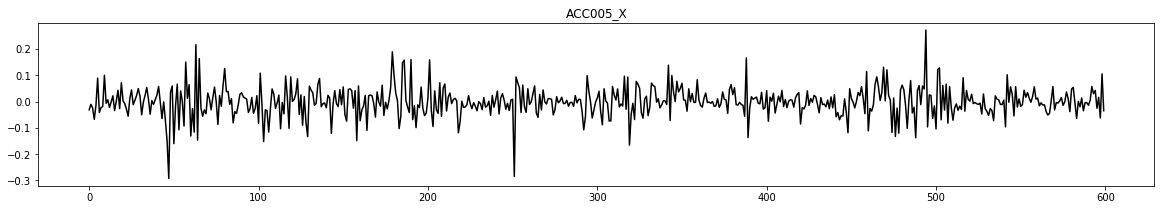

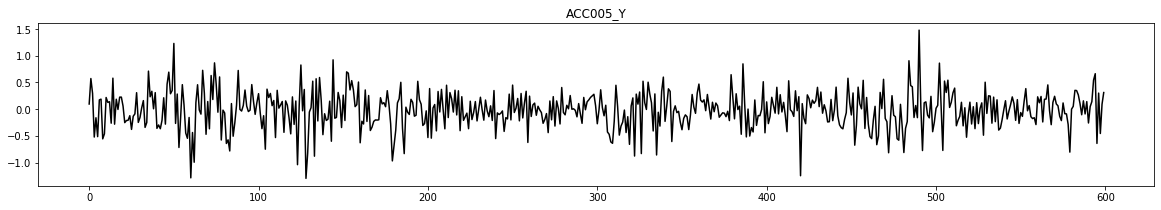

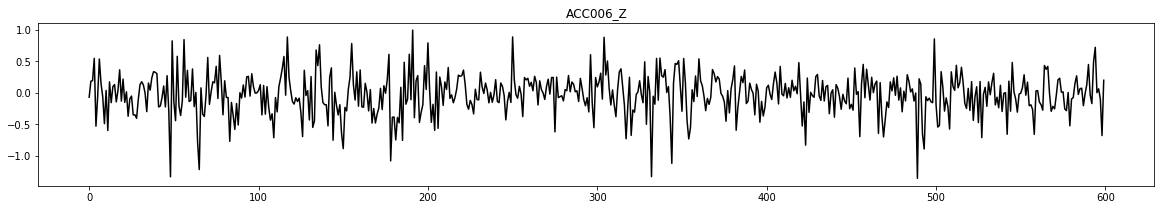

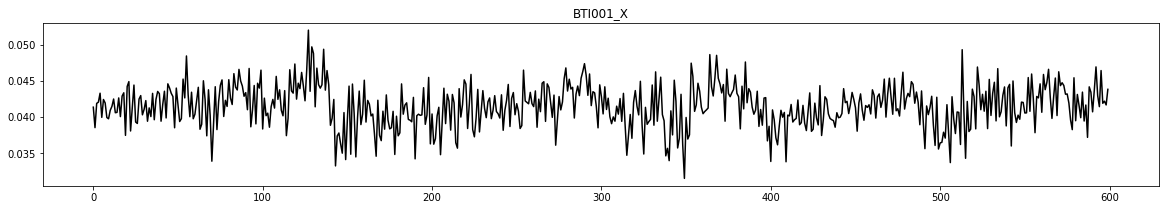

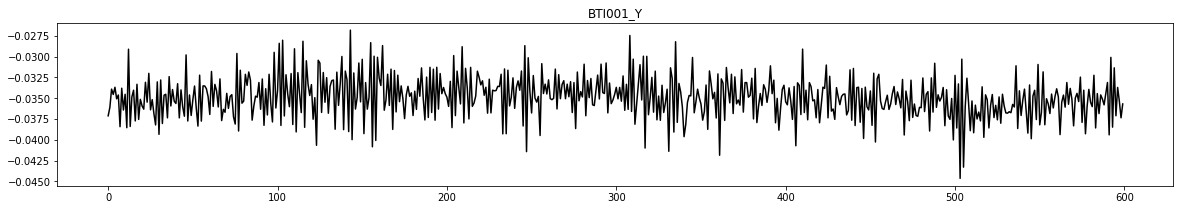

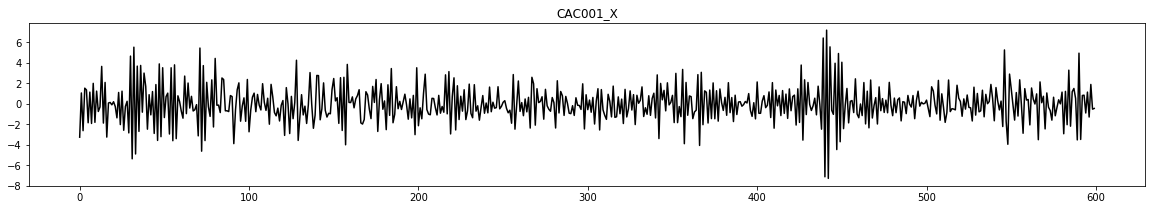

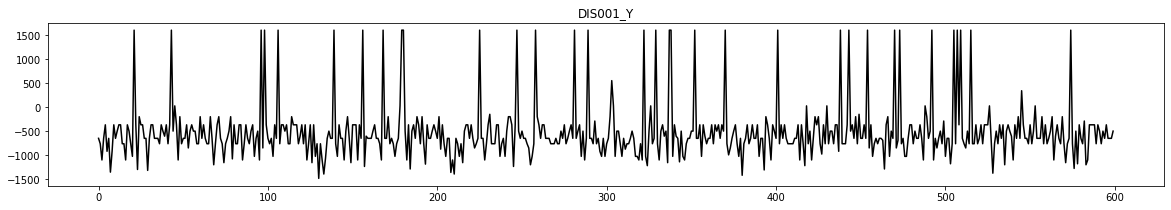

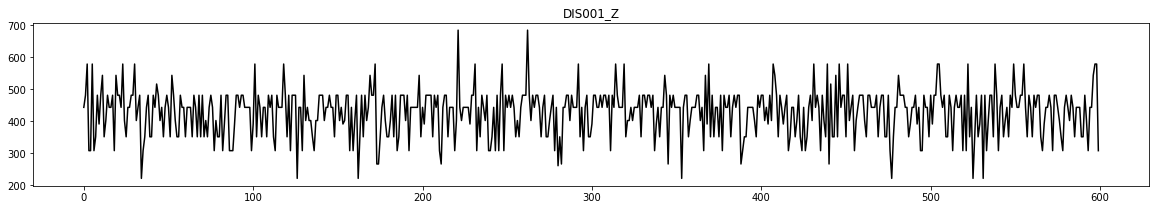

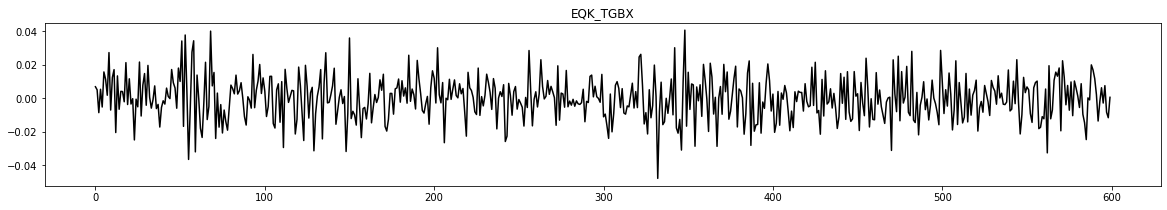

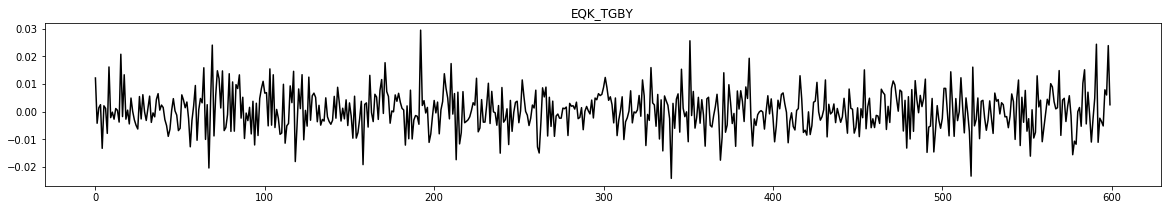

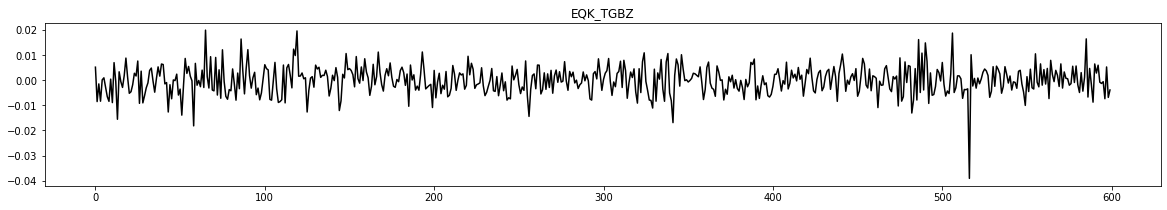

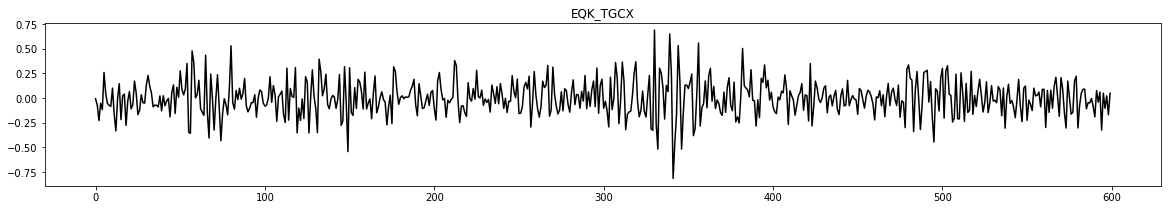

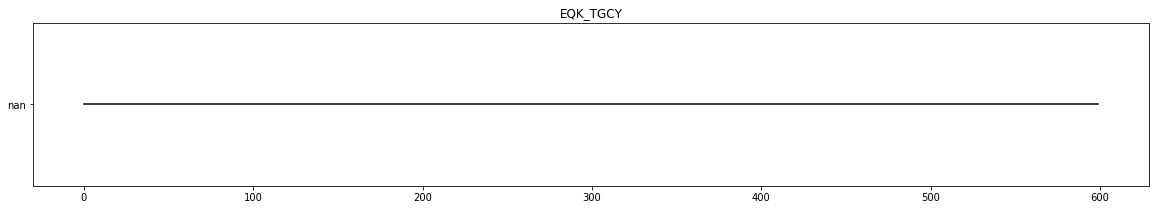

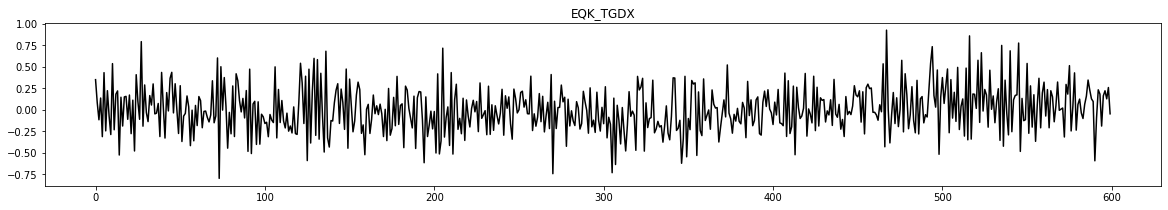

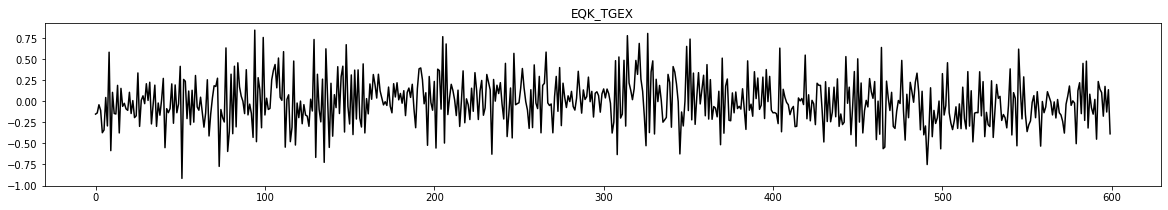

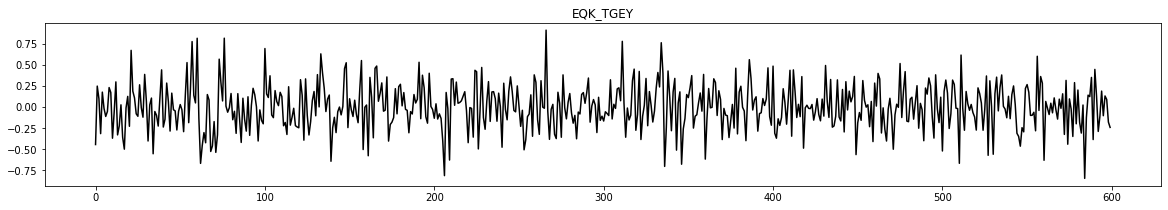

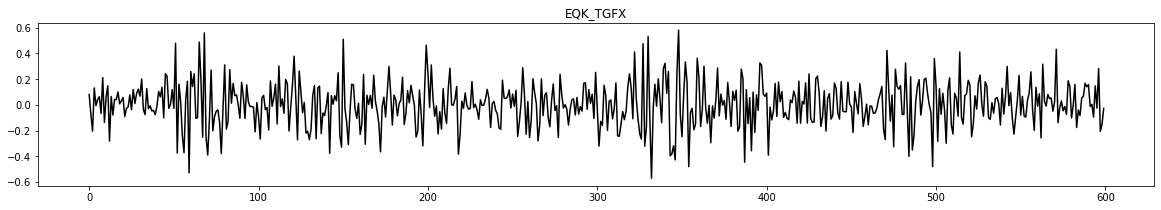

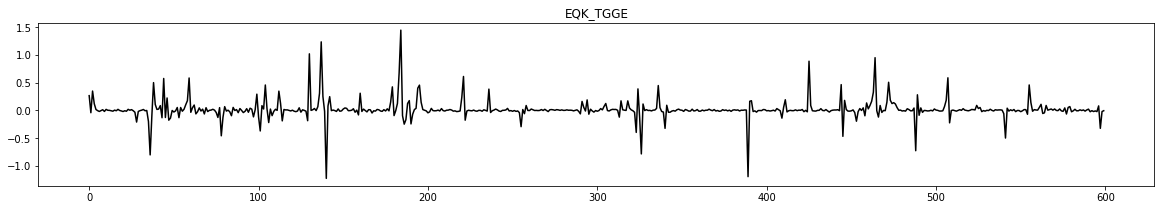

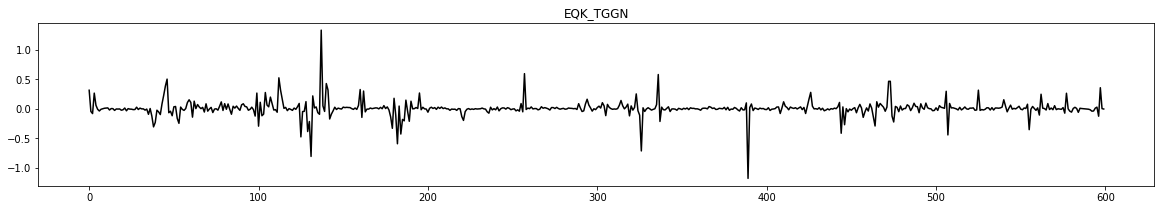

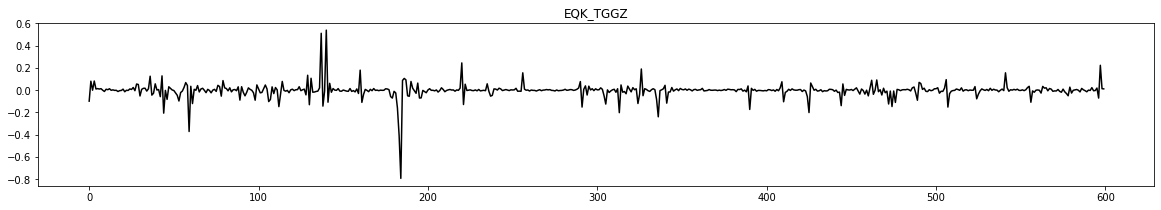

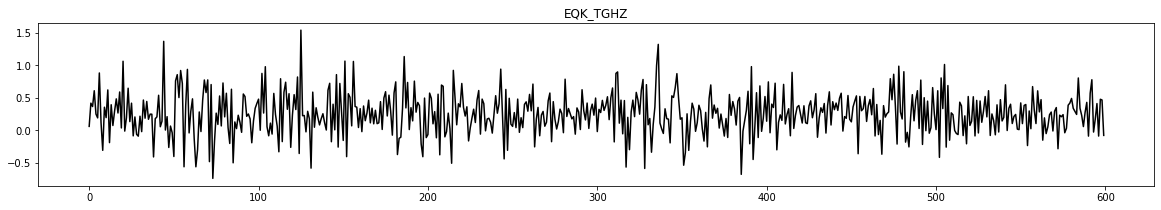

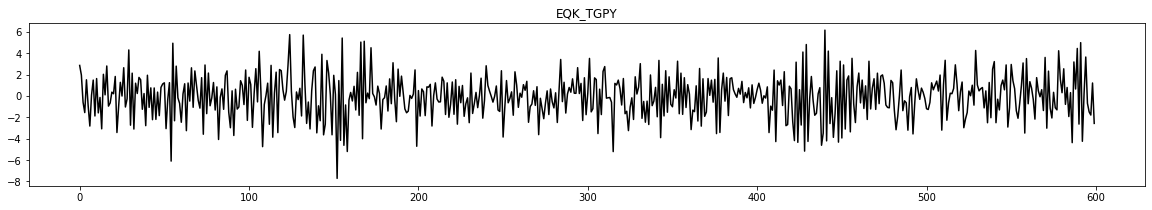

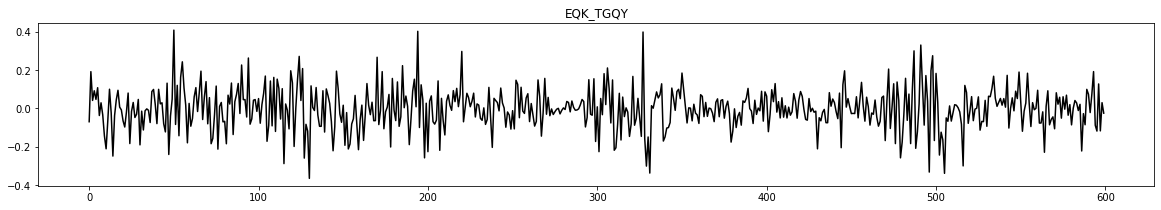

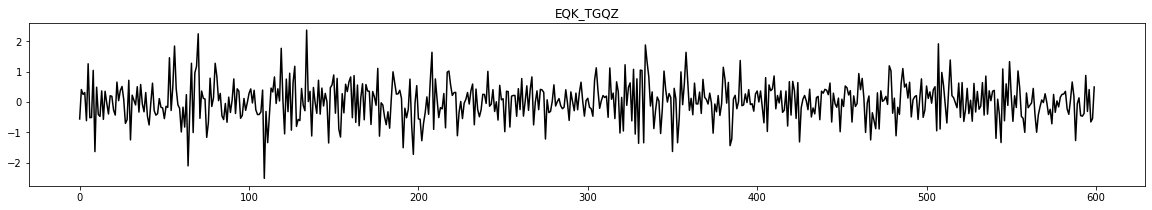

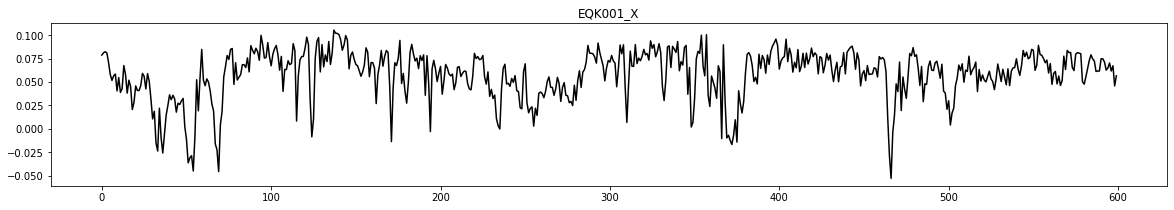

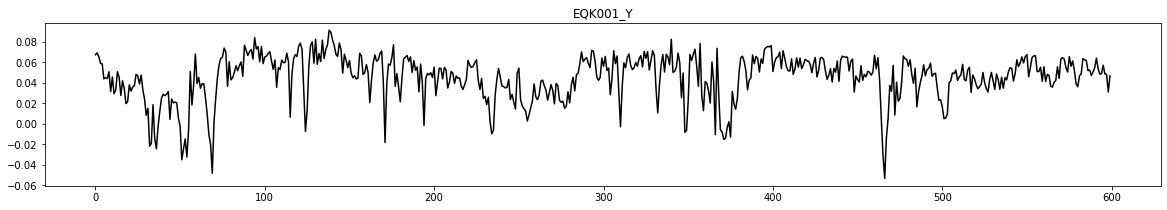

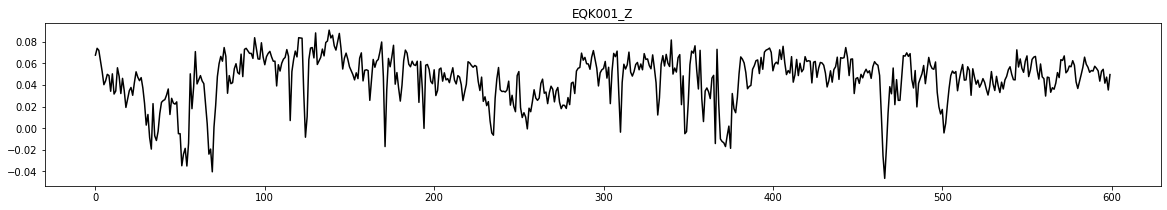

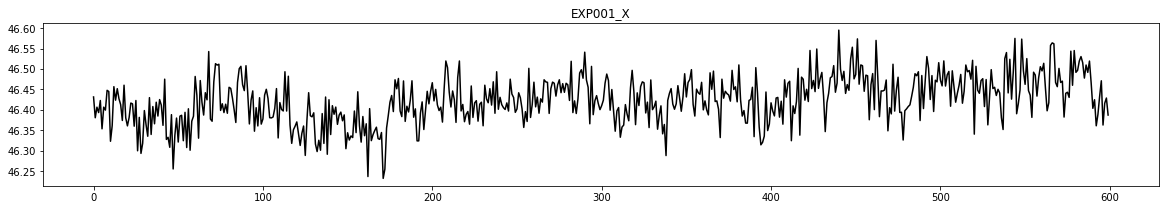

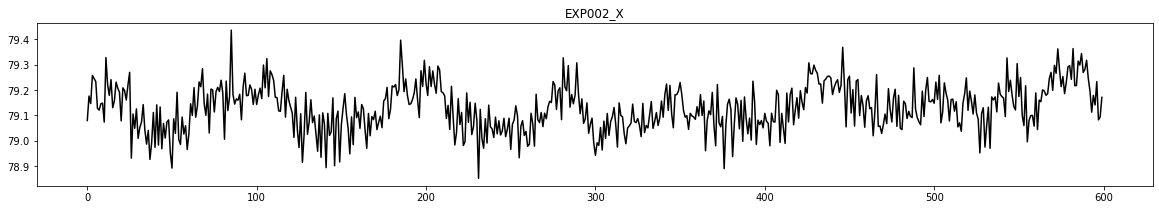

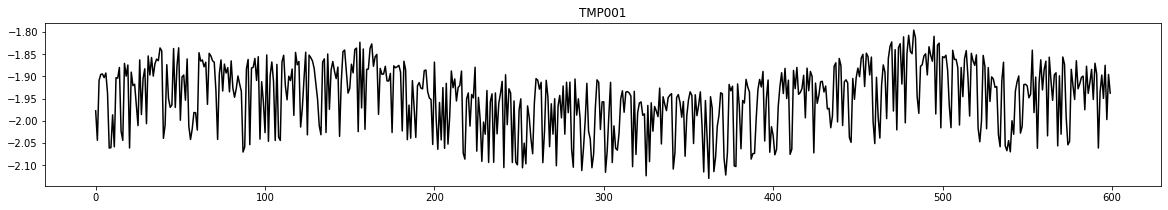

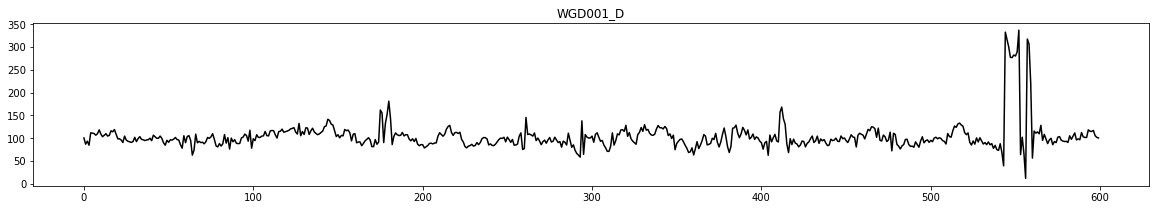

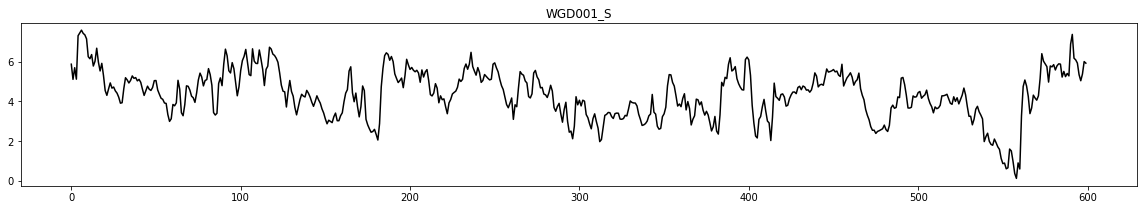


file name :  GBB_20191231234000.txt



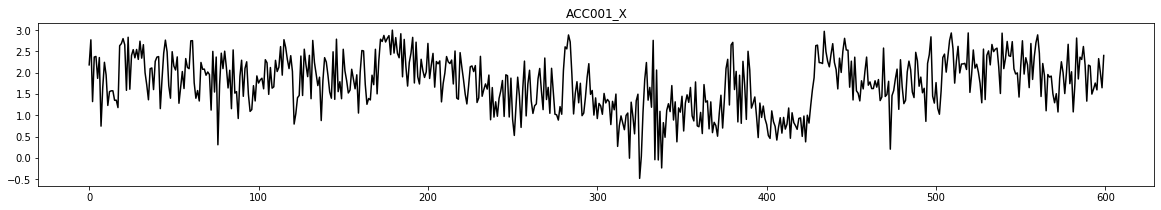

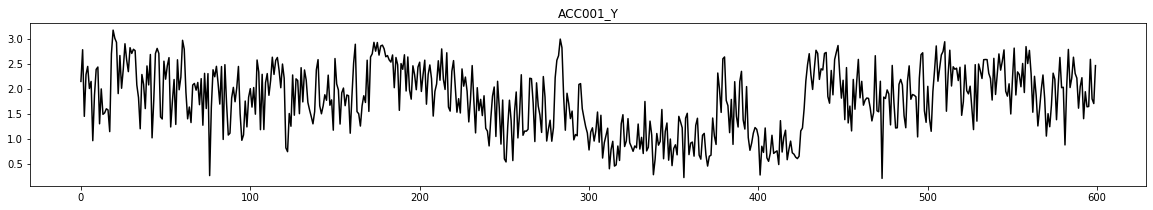

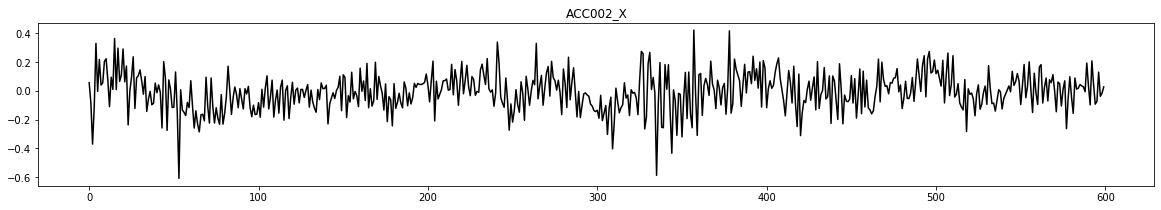

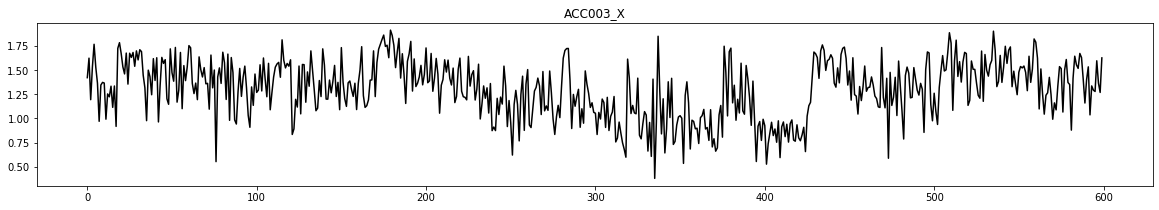

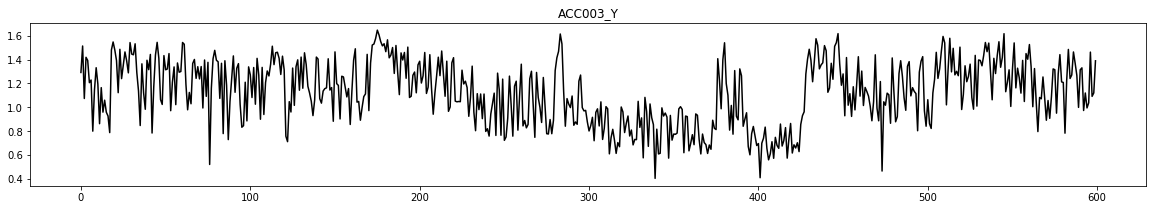

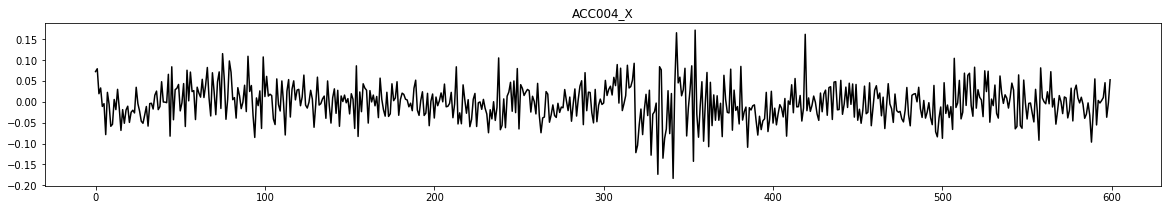

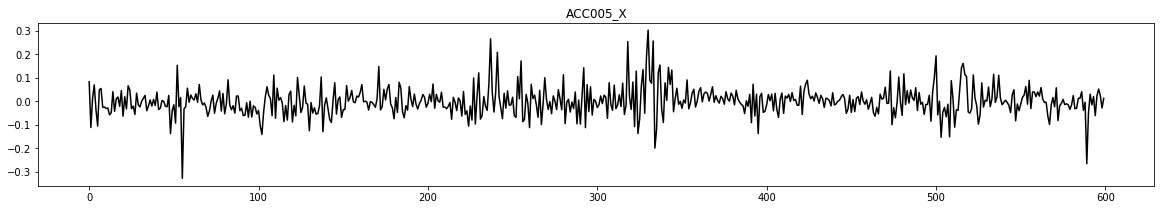

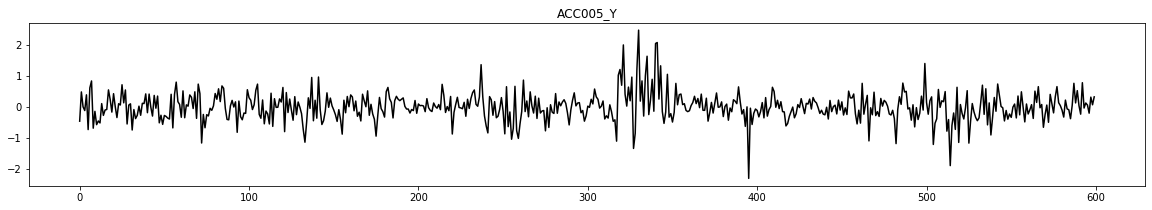

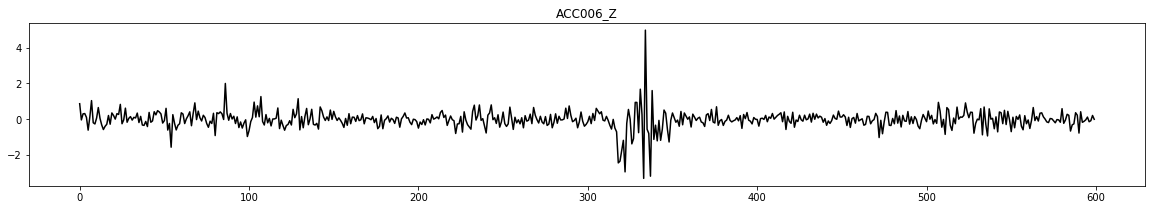

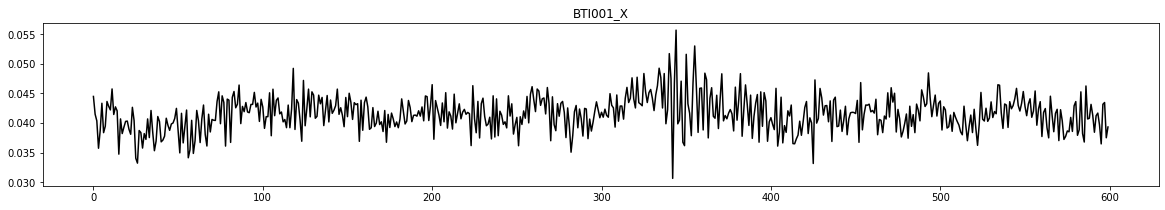

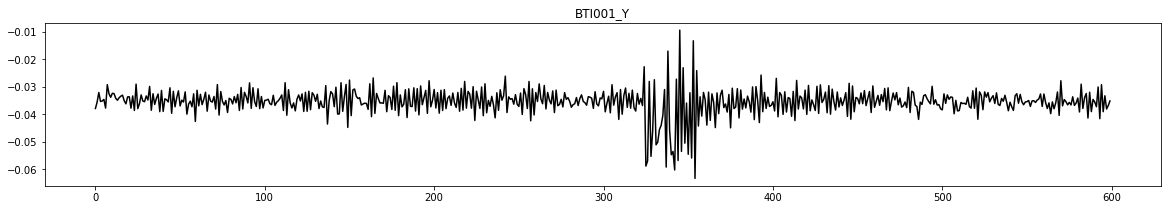

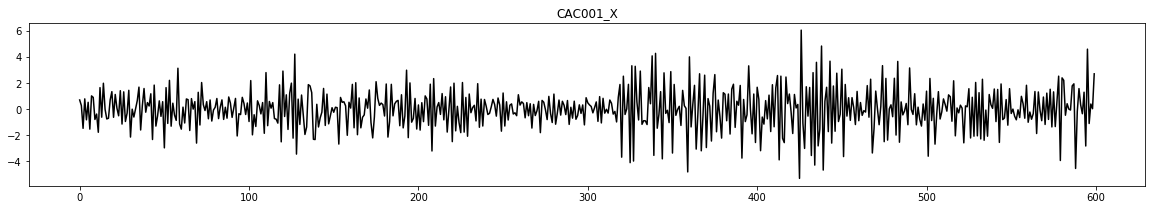

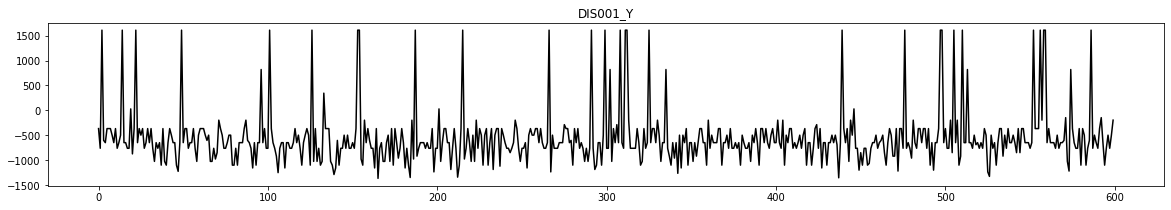

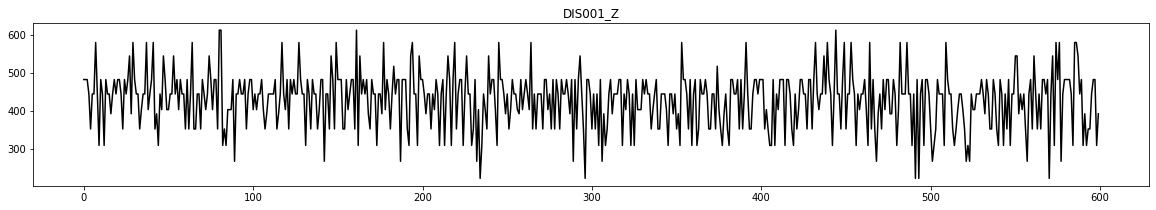

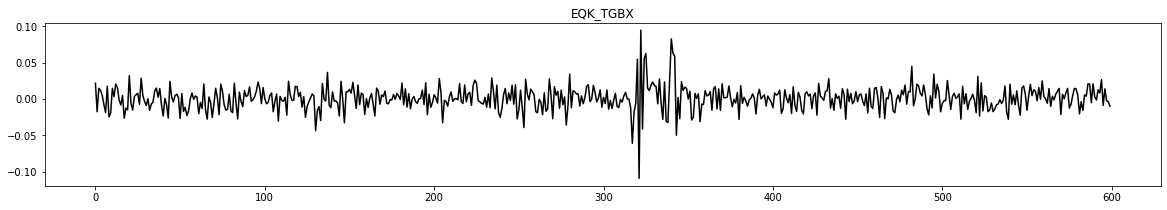

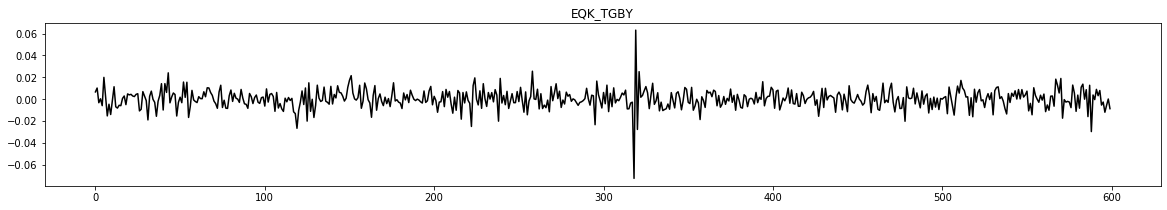

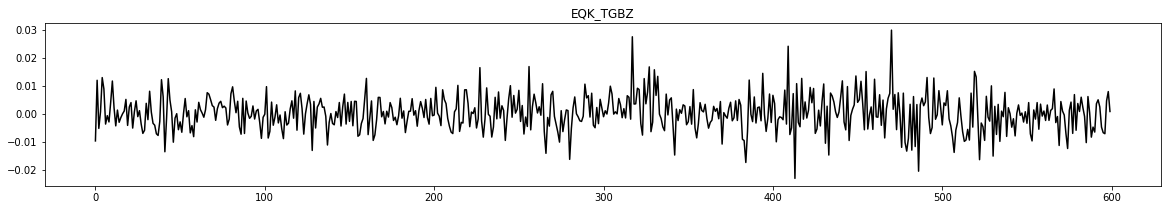

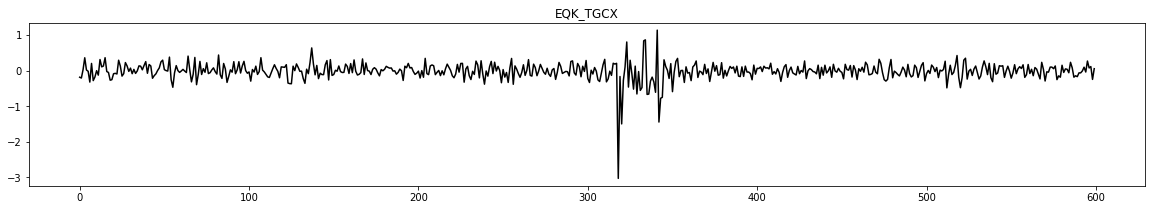

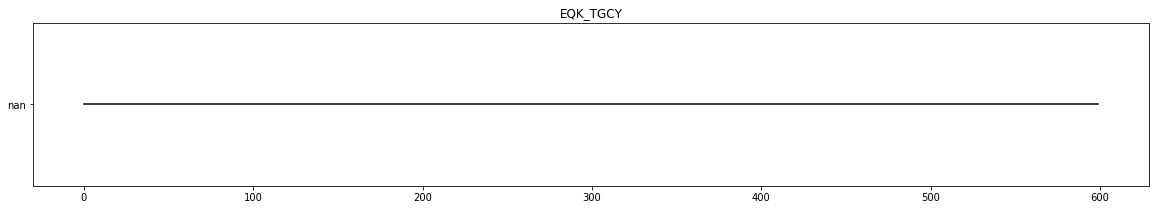

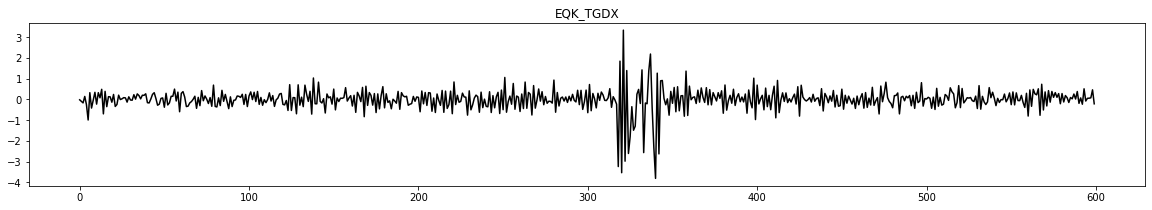

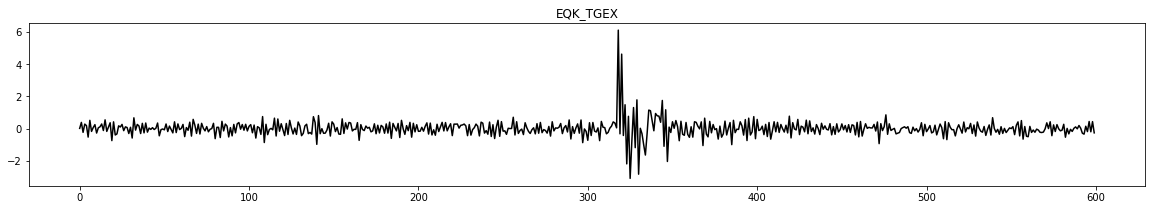

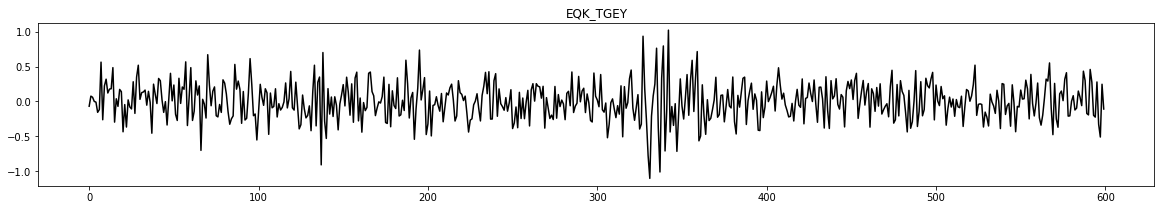

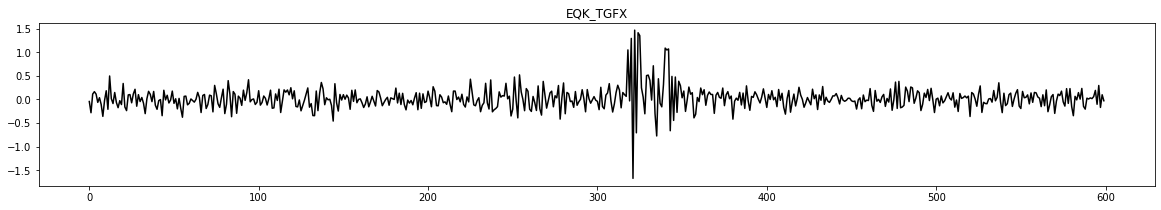

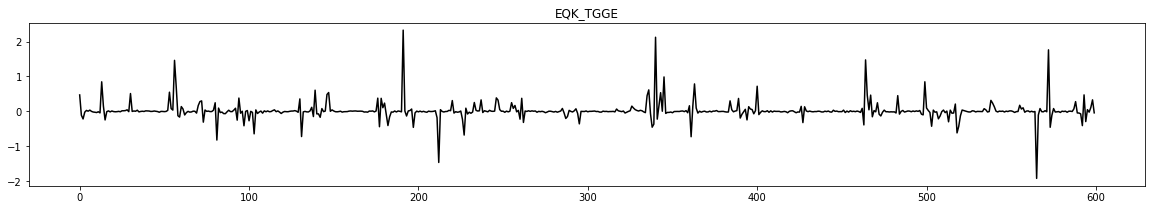

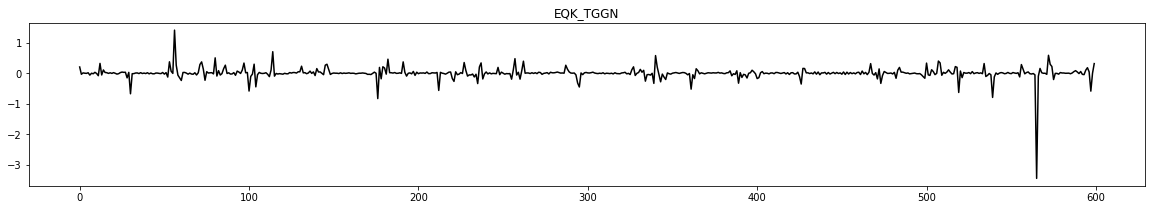

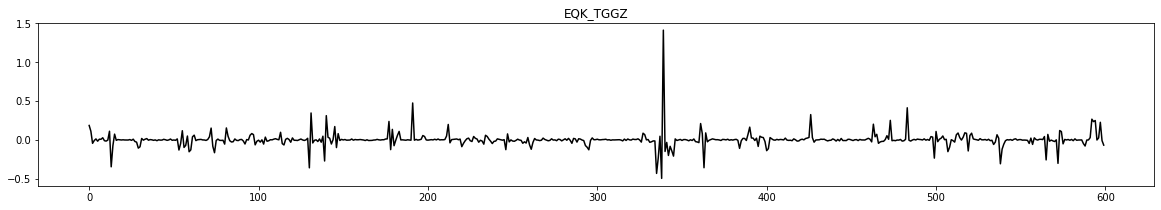

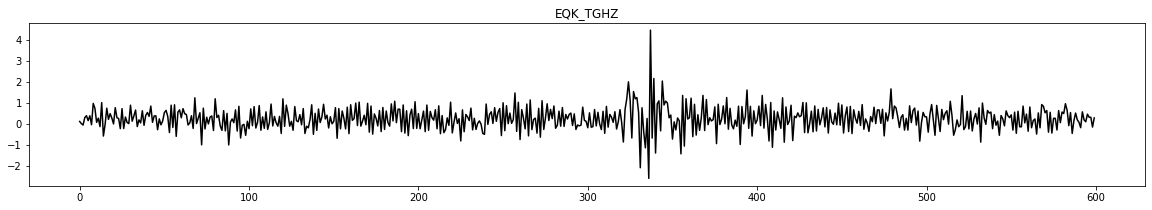

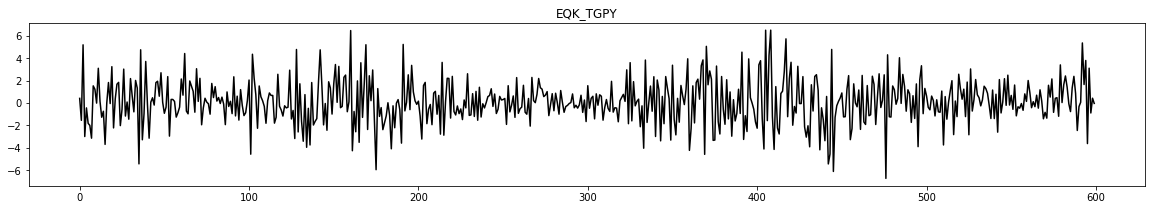

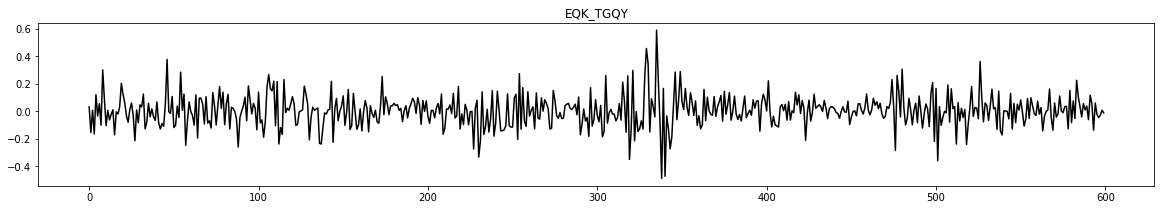

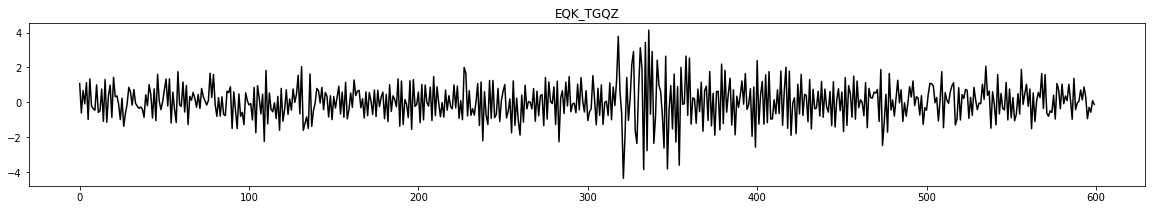

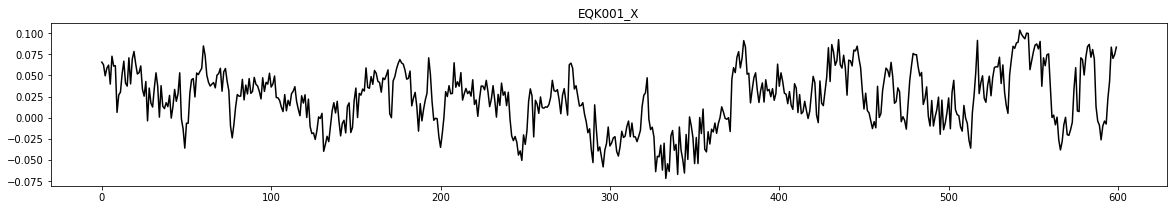

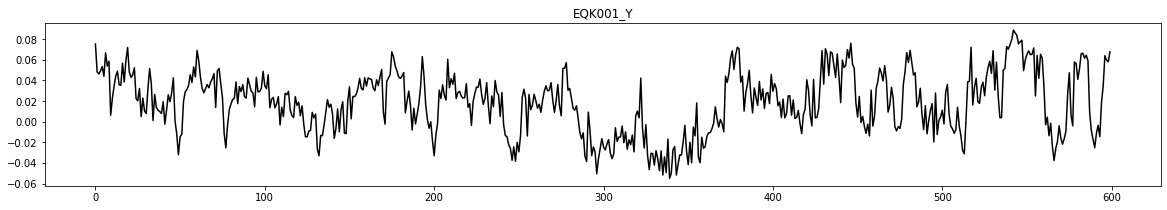

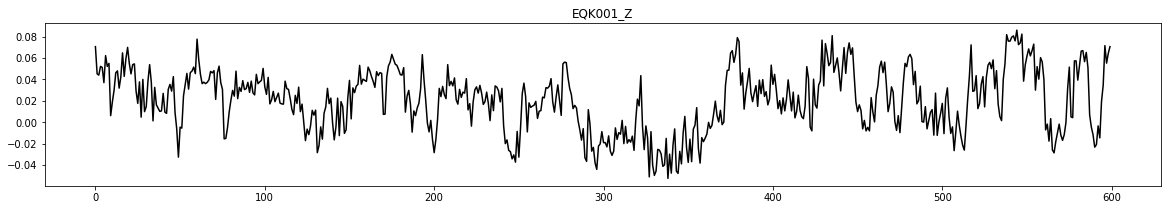

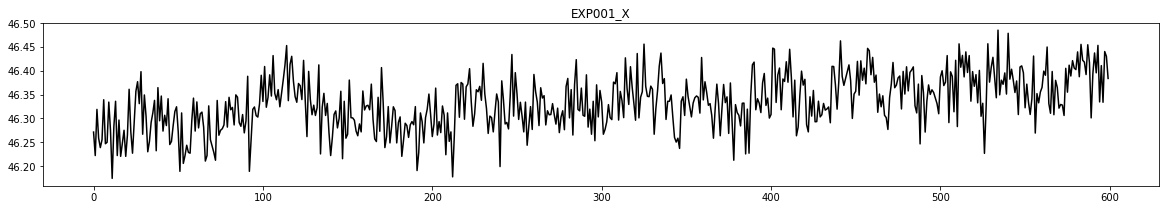

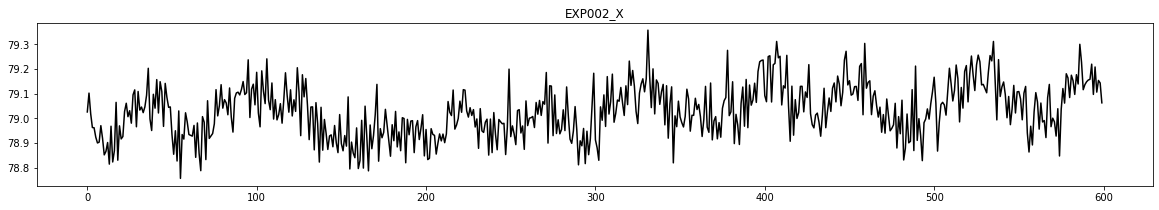

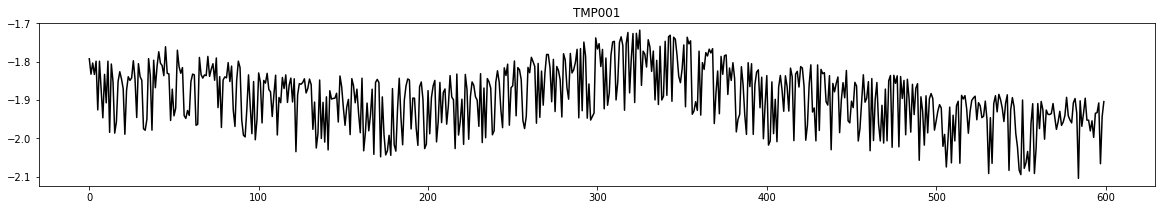

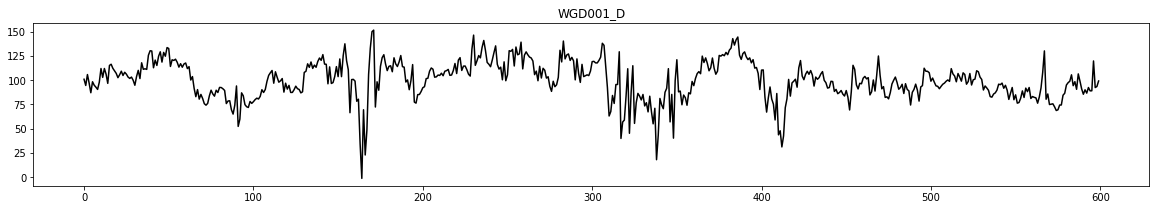

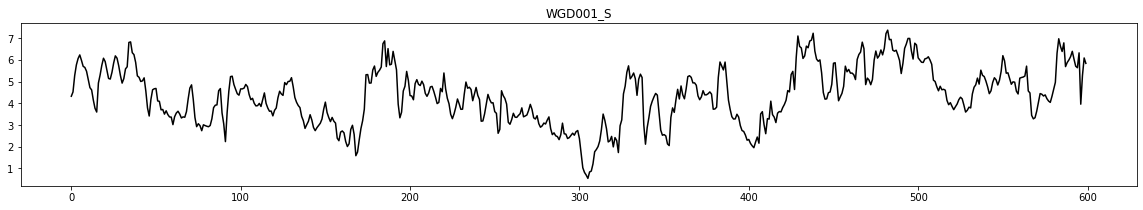


file name :  GBB_20191231233000.txt



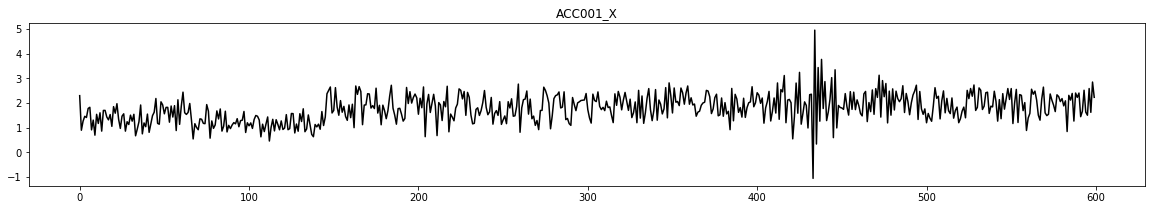

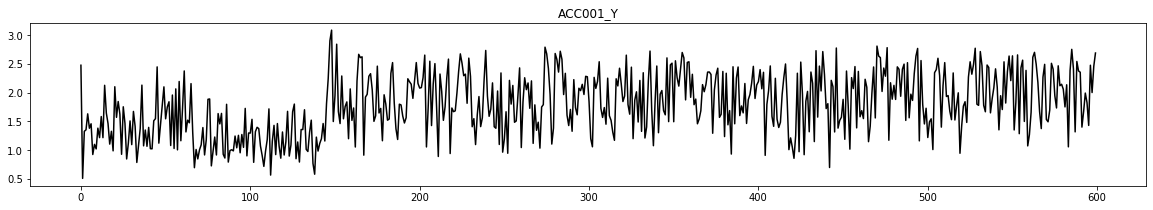

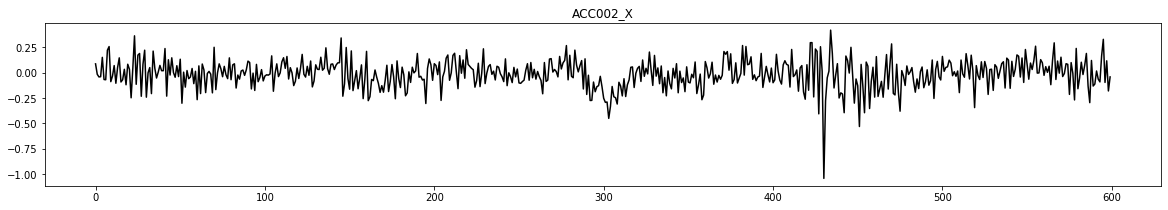

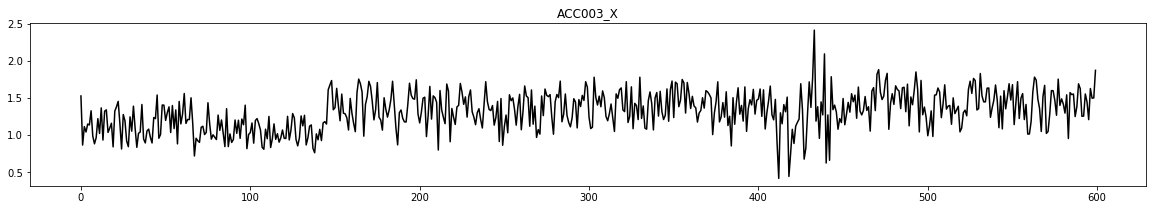

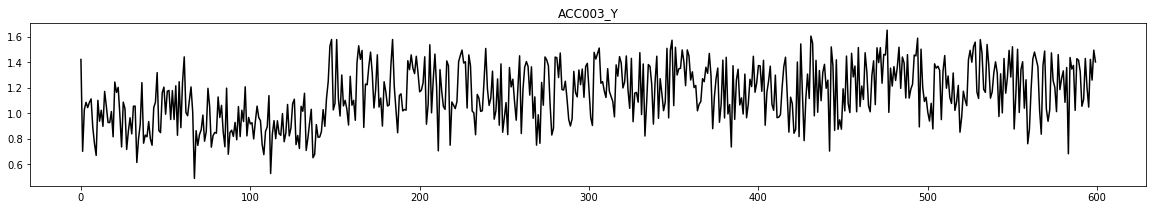

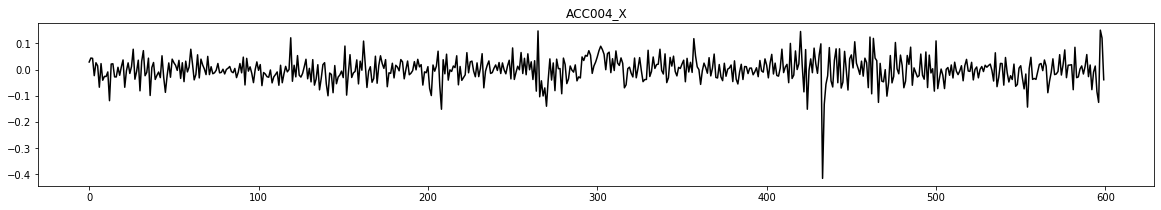

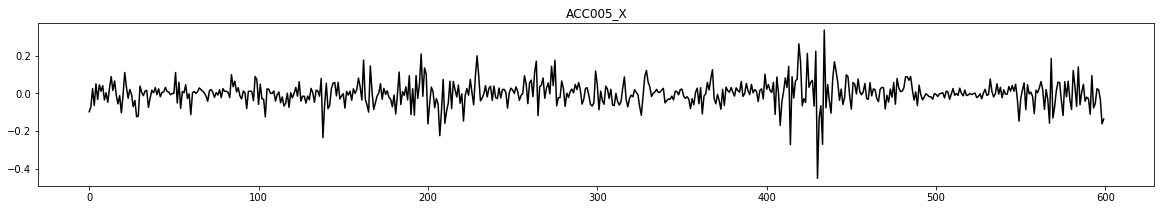

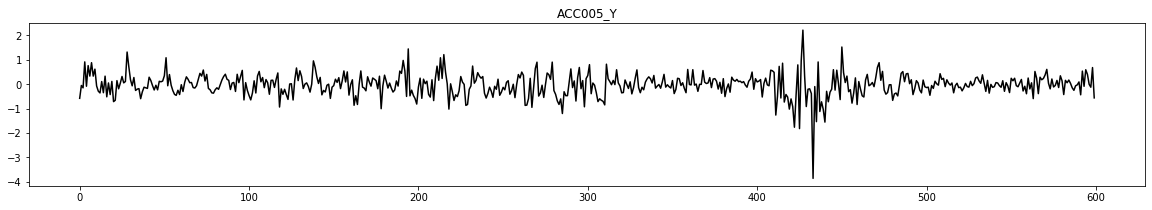

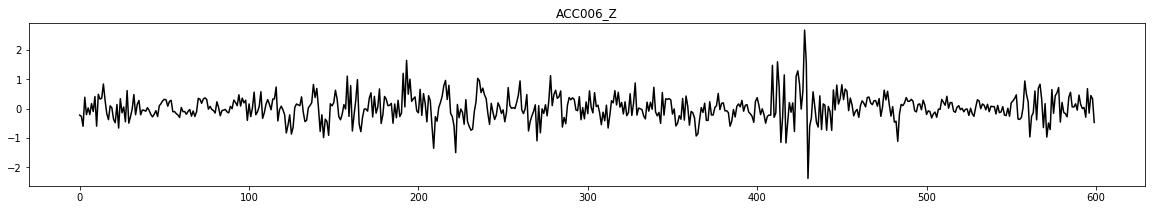

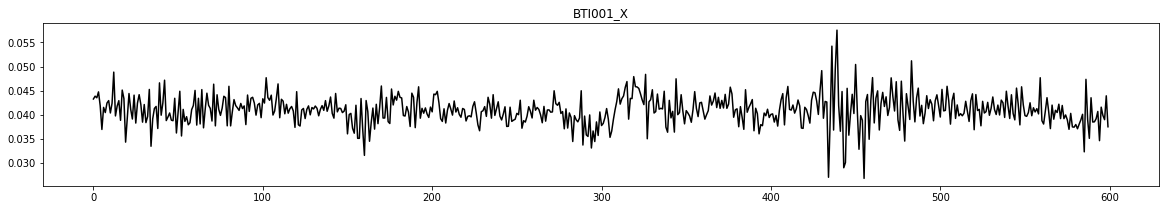

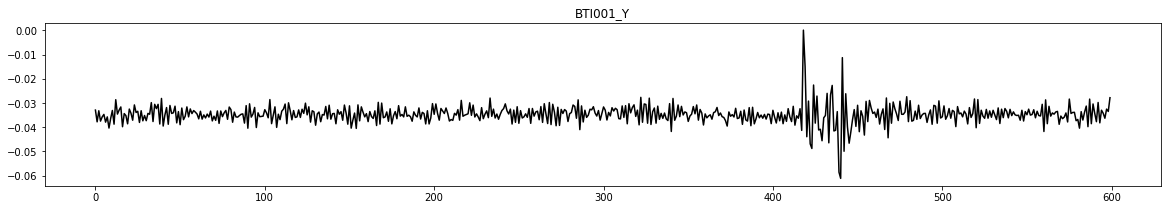

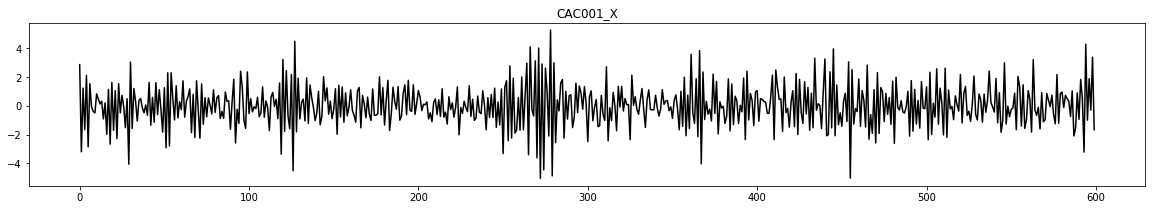

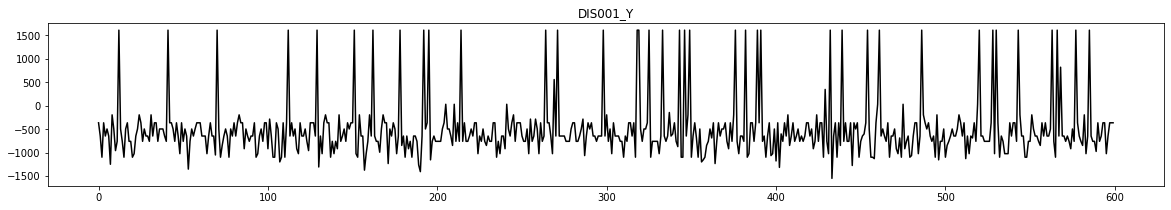

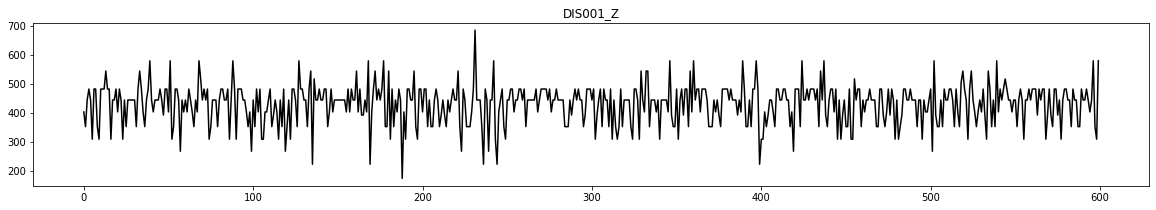

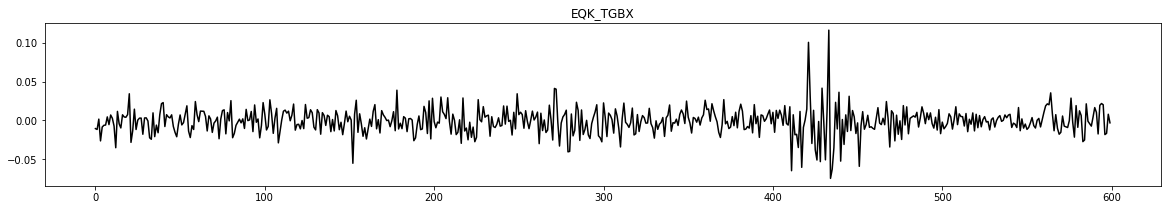

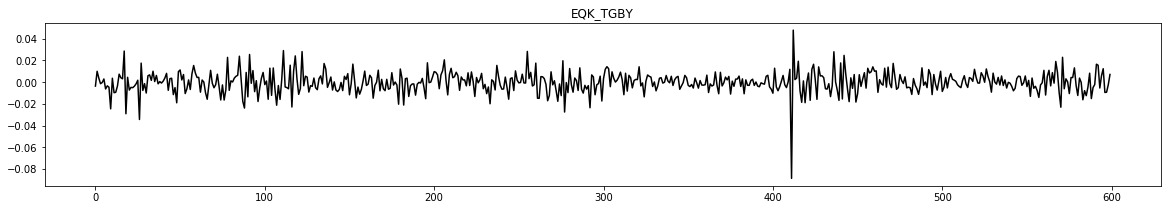

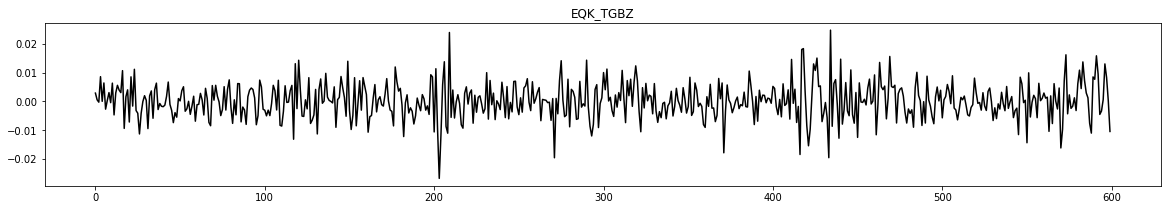

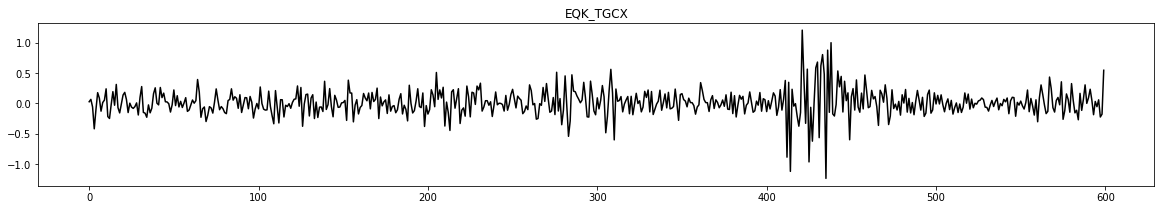

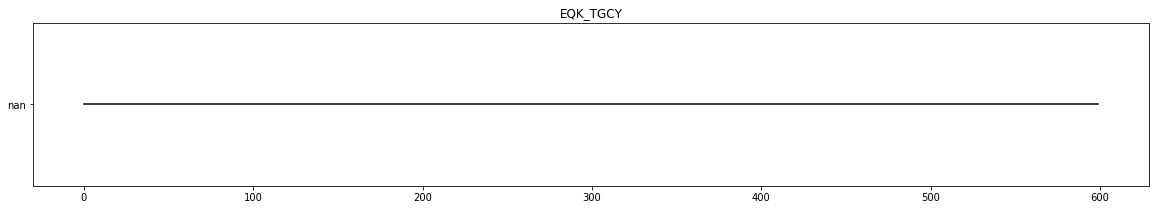

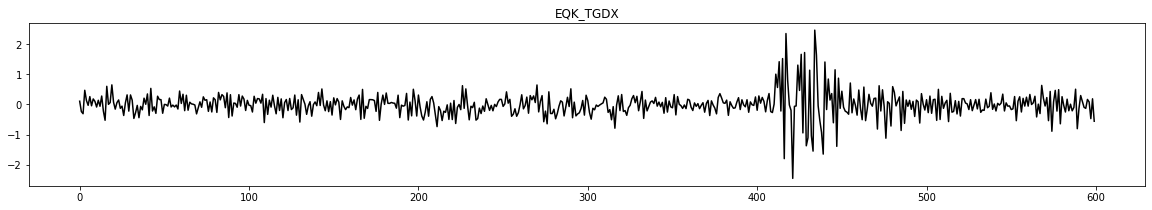

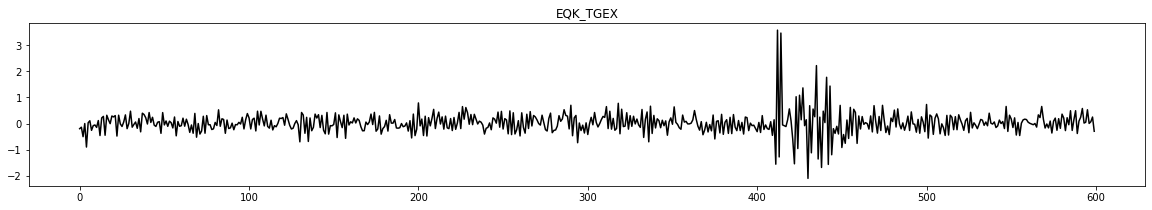

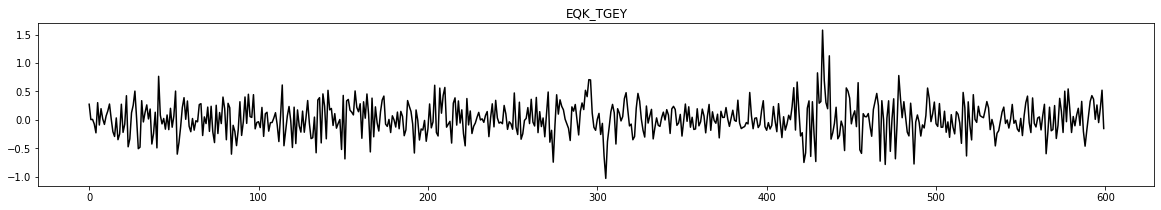

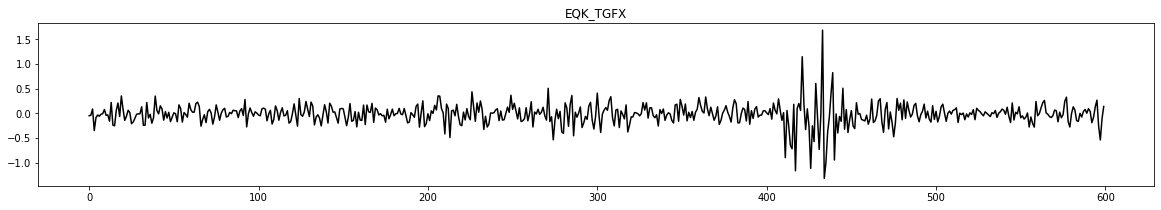

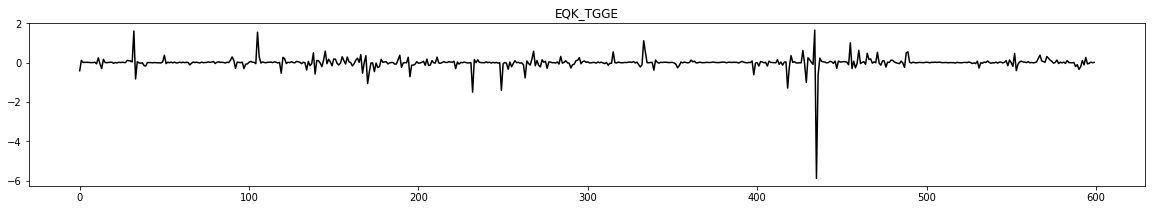

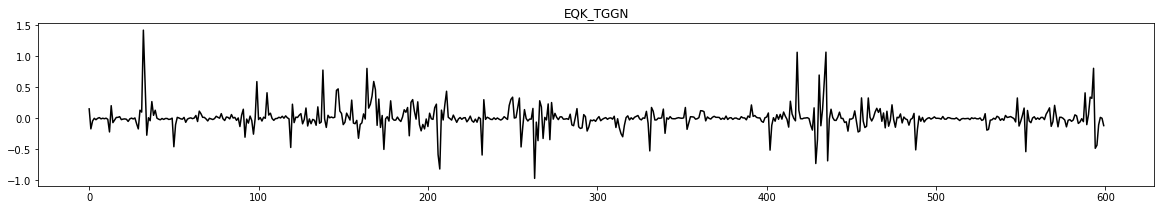

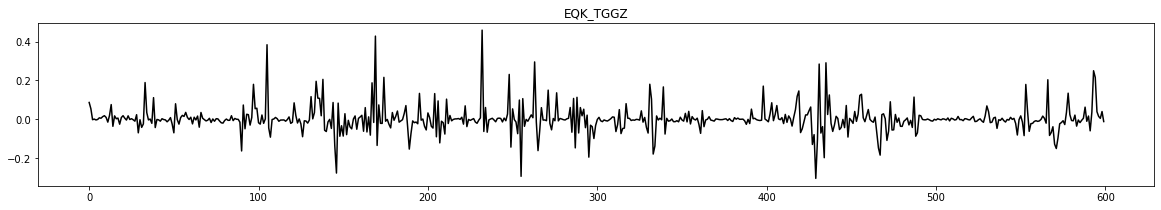

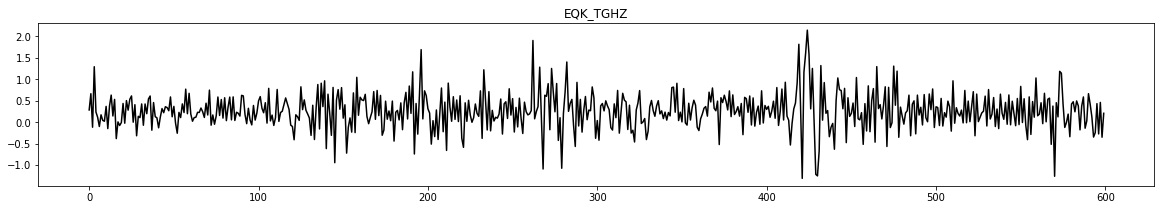

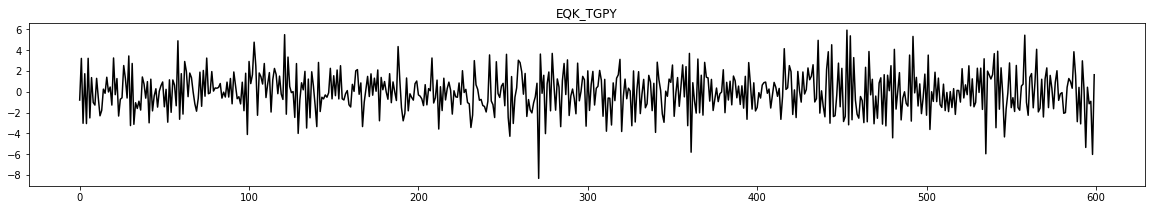

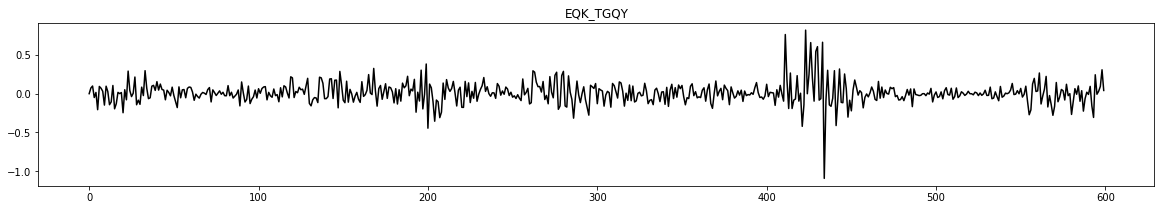

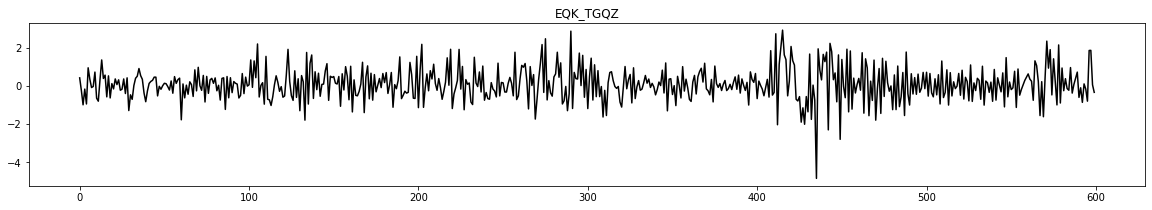

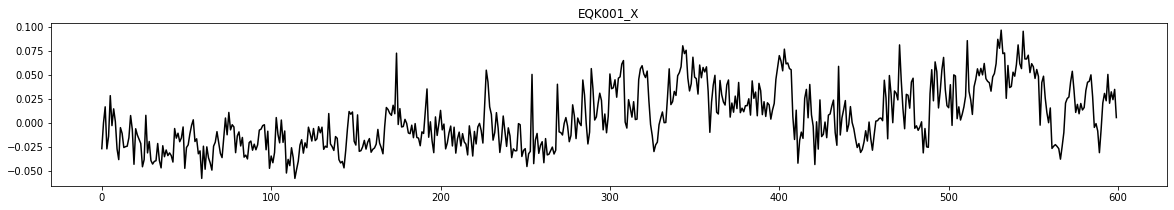

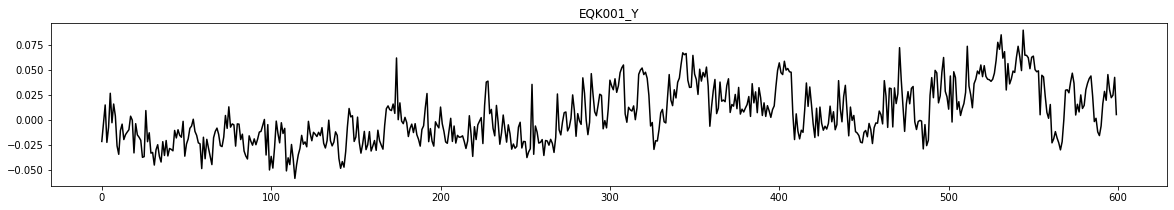

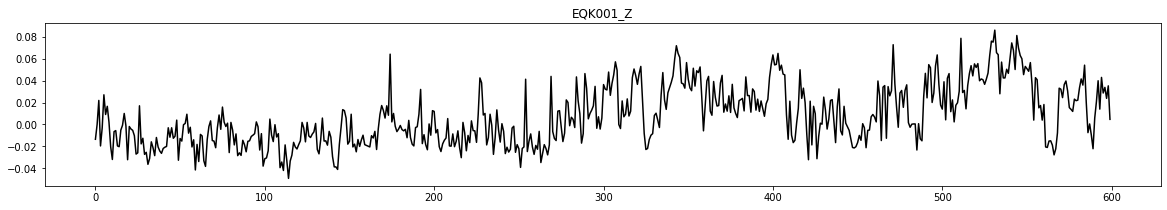

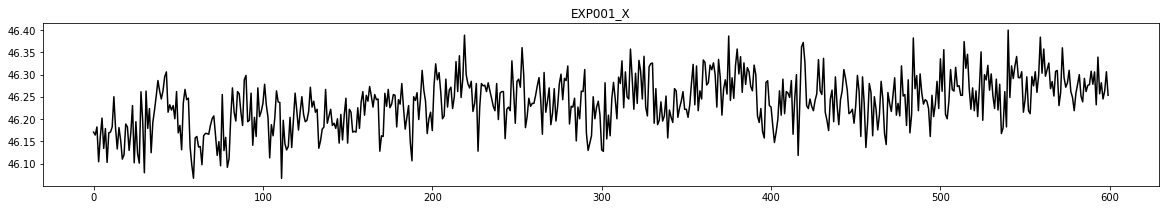

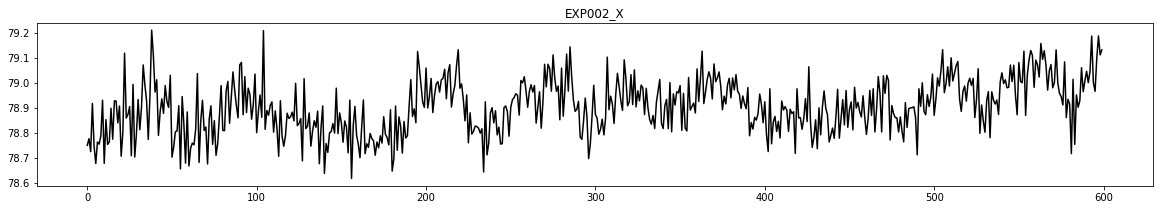

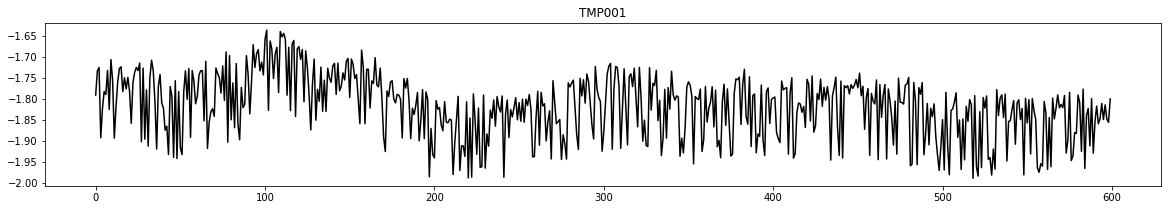

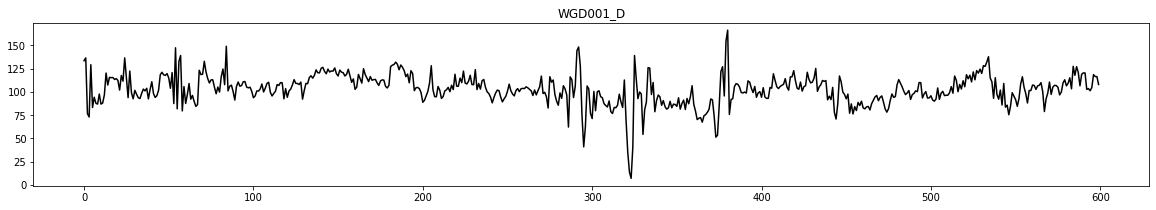

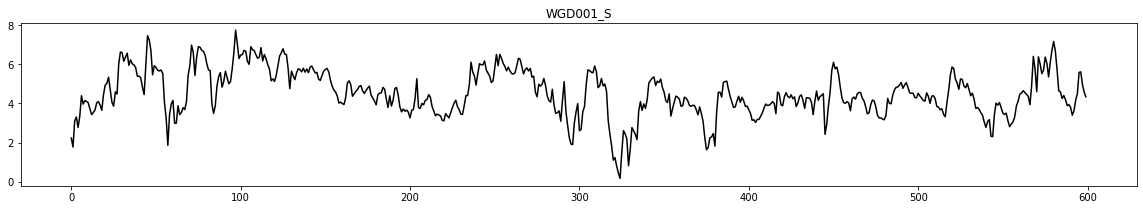

In [2]:
import matplotlib.pyplot as plt
for file_name in data.keys():
    
    print('\nfile name : ', file_name, end='\n\n')
    
    for key in data[file_name].keys():
        if key == '#Time':
            continue
        try:
            plt.figure(figsize=(20,3))
            plt.plot([d for i, d in enumerate(data[file_name][key]) if i%100 == 0], color='black')
            plt.title(key)
            plt.show()
        except:
            print('missing value detected')

In [1]:
from _preprocessing import *

params = dict()

# ------------------ preprocessing ------------------

params['source']          = 'STEAD'
params['window_count']    = 12
params['imbalance']       = False
params['condition']       = 'M>3'
params['config_name']     = make_config(params)

# ----------------- model-parameter -----------------

params['file_name']       = params['source'] + '_' + params['config_name'] + '_dump.pkl'
params['model_name']      = 'LSTM_' + params['config_name']
params['kernel_size']     = 20
params['embed_size']      = 512
params['hidden_size']     = 512

# ----------------- train-parameter -----------------

params['epochs']          = 100
params['lr']              = 0.001

preprocessing(params)

file exist!!!


In [2]:
from _utils import *

dataset = load_dataset(params)

DEVICE 		:  cuda:1
pid 		:  5538

---------------------------------Data---------------------------------

file name 	: STEAD_W12_M>3_balance_dump.pkl
data length 	: 20000
T/F count 	: 10000 / 10000
T/F ratio 	: 50.0 %

Train size 	: 14000
Valid size 	: 1500
Test size 	: 4500

x shape 	: torch.Size([20000, 3, 6000])
y_p shape 	: torch.Size([20000, 1, 12])

------------------------------Data Loader------------------------------

X_train :  torch.Size([500, 3, 6000])  	type :  torch.FloatTensor
y_train :  torch.Size([500, 1, 12])  	type :  torch.FloatTensor


In [7]:
for (X_train, y_train) in dataset['train_loader'] : 
        print('X_train : ', X_train.size() , ' \ttype : ', X_train.type())
        print('y_train : ', y_train.size() , ' \ttype : ', y_train.type())
        break

X_train :  torch.Size([500, 3, 6000])  	type :  torch.FloatTensor
y_train :  torch.Size([500, 1, 12])  	type :  torch.FloatTensor


In [9]:
X_train[0,0]

tensor([-56.3889, -57.8527, -54.4362,  ...,  52.8840,  58.6921,  77.0801])

In [57]:
def get_snr(data, pat, window=200):
    
    """ 
    
    Estimates SNR.
    
    Parameters
    ----------
    data : numpy array
        3 component data.    
        
    pat: positive integer
        Sample point where a specific phase arrives. 
        
    window: positive integer, default=200
        The length of the window for calculating the SNR (in the sample).         
        
    Returns
   --------   
    snr : {float, None}
       Estimated SNR in db. 
       
        
    """      
       
    snr = None
    if pat < window/2 or len(data) - pat < window/2:
        return 0
    
    try:
        if int(pat) >= window and (int(pat)+window) < len(data):
            nw1 = data[int(pat)-window : int(pat)];
            sw1 = data[int(pat) : int(pat)+window];
            snr = round(10*math.log10((np.percentile(sw1,95)/np.percentile(nw1,95))**2), 1)           
        elif int(pat) < window and (int(pat)+window) < len(data):
            window = int(pat)
            nw1 = data[int(pat)-window : int(pat)];
            sw1 = data[int(pat) : int(pat)+window];
            snr = round(10*math.log10((np.percentile(sw1,95)/np.percentile(nw1,95))**2), 1)
        elif (int(pat)+window) > len(data):
            window = len(data)-int(pat)
            nw1 = data[int(pat)-window : int(pat)];
            sw1 = data[int(pat) : int(pat)+window];
            snr = round(10*math.log10((np.percentile(sw1,95)/np.percentile(nw1,95))**2), 1)    
    except Exception:
        return 0
    return snr 

In [72]:
def get_hmm(data, pat, window=200):
       
    hmm = None
    if pat < window/2 or len(data) - pat < window/2:
        return 0
    
    try:
        if int(pat) < 2*window:
            window = int(pat)
            
        nw1 = data[int(pat)-2*window : int(pat)-window];
        sw1 = data[int(pat)-window : int(pat)];
        ratio = np.percentile(sw1,95)/np.percentile(nw1,95)
        
        if ratio > 2:
            hmm = 1
        else:
            hmm = 0
    except Exception:
        return 0
    
    return hmm 

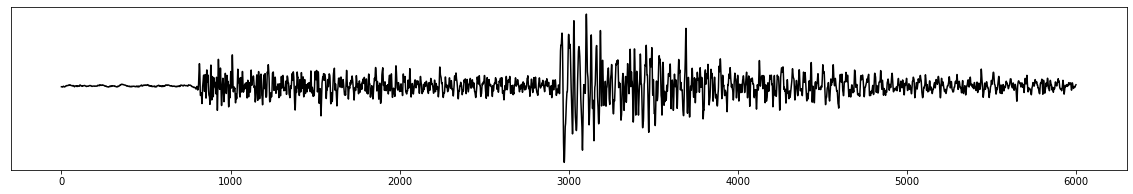

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import math

plt.figure(figsize=(20,3))
plt.gca().axes.yaxis.set_visible(False)
plt.plot(X_train[0,0], color = 'black' if 1 in y_train[0] else 'r')

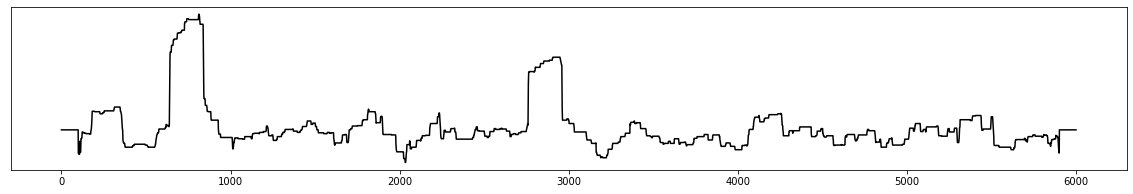

In [78]:
X_train_snr = np.zeros(6000)

for idx in range(6000):
    X_train_snr[idx] = get_snr(X_train[0,0], idx)

plt.figure(figsize=(20,3))
plt.gca().axes.yaxis.set_visible(False)
plt.plot(X_train_snr, color = 'black' if 1 in y_train[0] else 'r')

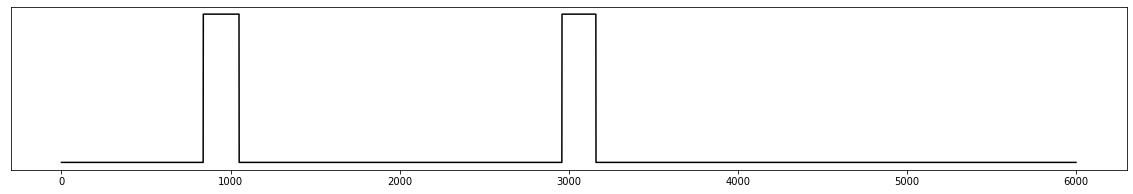

In [79]:
X_train_hmm = np.zeros(6000)

for idx in range(6000):
    X_train_hmm[idx] = get_hmm(X_train[0,0], idx, window=200)

plt.figure(figsize=(20,3))
plt.gca().axes.yaxis.set_visible(False)
plt.plot(X_train_hmm, color = 'black' if 1 in y_train[0] else 'r')

total events in csv file: 100
total events selected: 100
random choice length : 100


109C.TA_20060723155859_EV


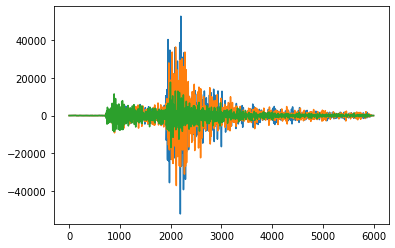

109C.TA_20061103155652_EV


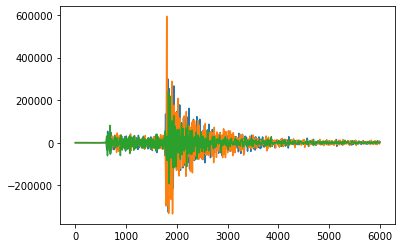

109C.TA_20061103161223_EV


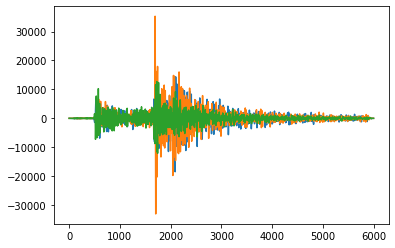

109C.TA_20061114133221_EV


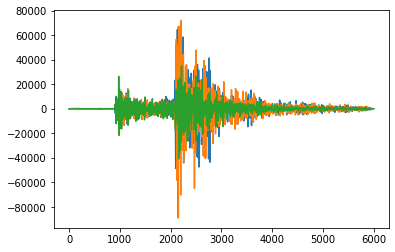

109C.TA_20061127104640_EV


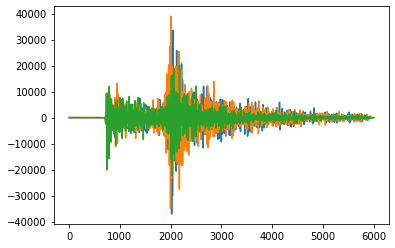

109C.TA_20061129121745_EV


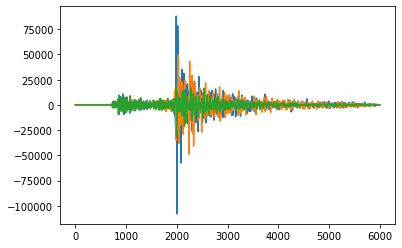

109C.TA_20061129211102_EV


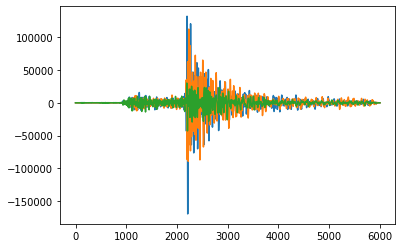

109C.TA_20061129211301_EV


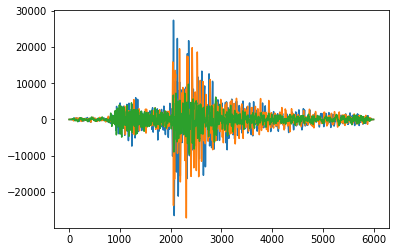

109C.TA_20061129221547_EV


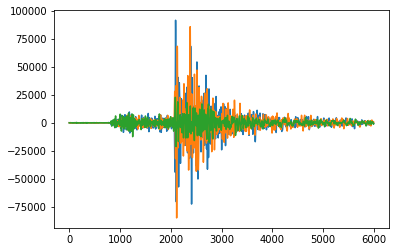

109C.TA_20070109140205_EV


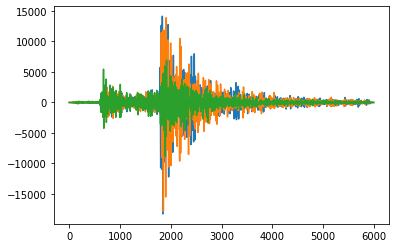

109C.TA_20070117160753_EV


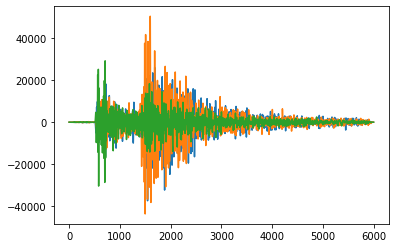

109C.TA_20070209033349_EV


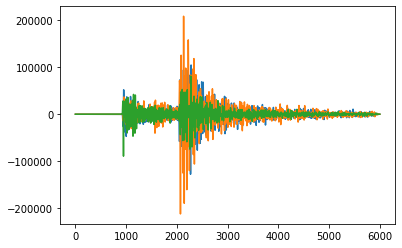

109C.TA_20070226181833_EV


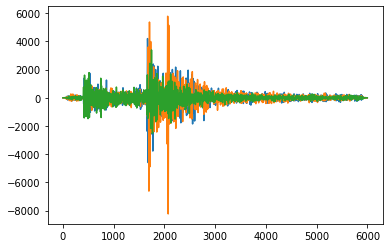

109C.TA_20070301143752_EV


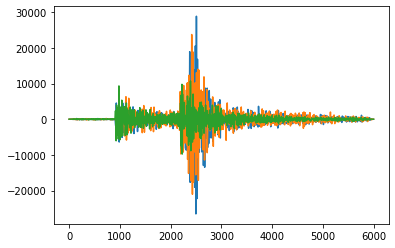

109C.TA_20070306033340_EV


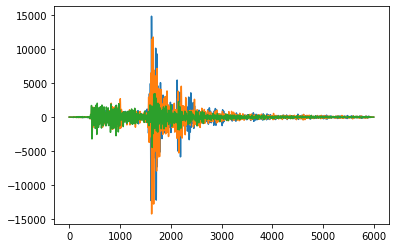

109C.TA_20070415225732_EV


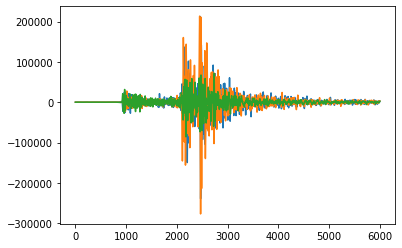

109C.TA_20070416034531_EV


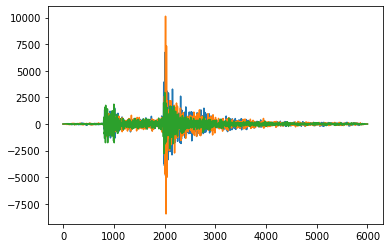

109C.TA_20070418093344_EV


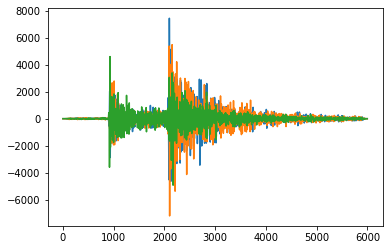

109C.TA_20070418222316_EV


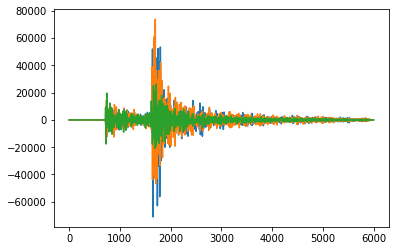

109C.TA_20070419113340_EV


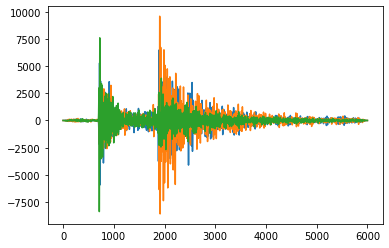

109C.TA_20070419120129_EV


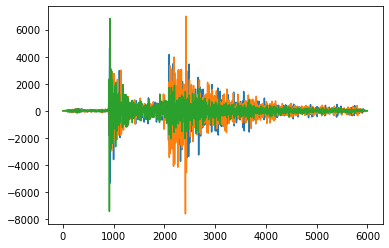

109C.TA_20070525113536_EV


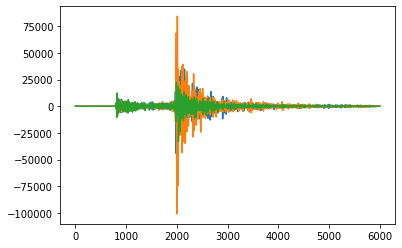

109C.TA_20070525114806_EV


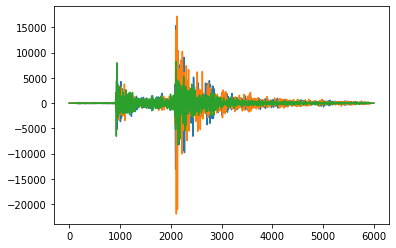

109C.TA_20070608061311_EV


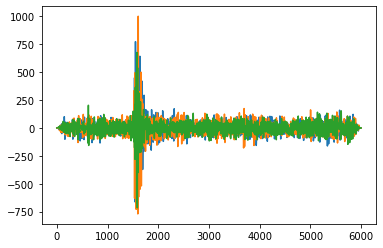

109C.TA_20070609212927_EV


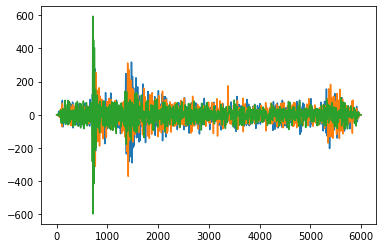

109C.TA_20070610114701_EV


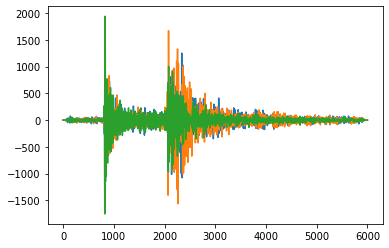

109C.TA_20070610115123_EV


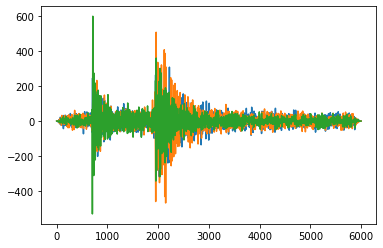

109C.TA_20070610234242_EV


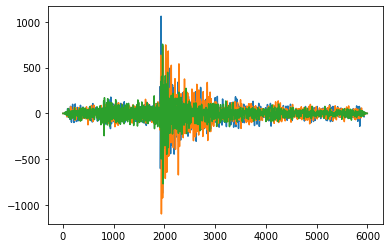

109C.TA_20070612100856_EV


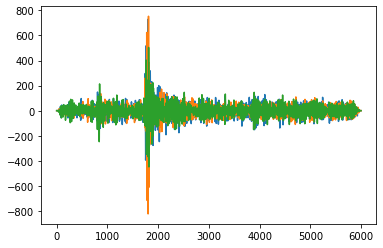

109C.TA_20070613030646_EV


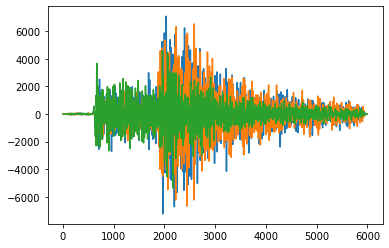

109C.TA_20070616163138_EV


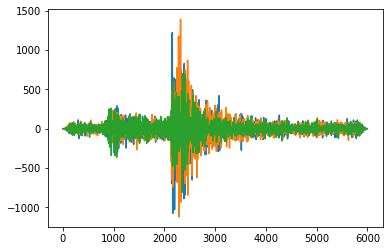

109C.TA_20070617203107_EV


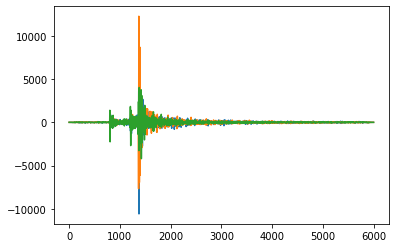

109C.TA_20070623050227_EV


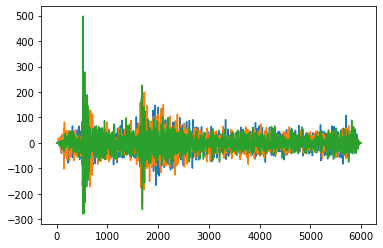

109C.TA_20070627010414_EV


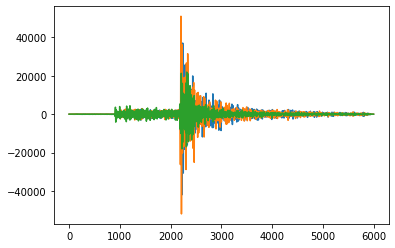

109C.TA_20070628195508_EV


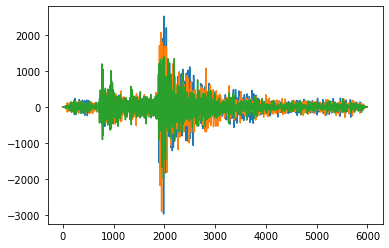

109C.TA_20070630182442_EV


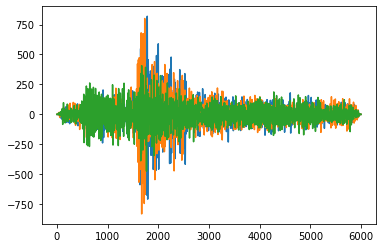

109C.TA_20070703234657_EV


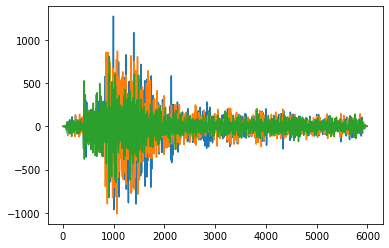

109C.TA_20070705115037_EV


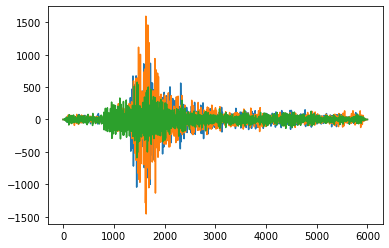

109C.TA_20070706182900_EV


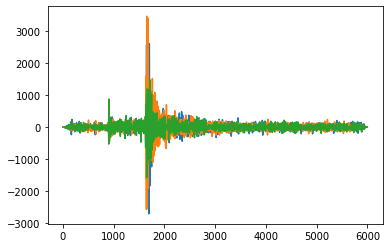

109C.TA_20070706203254_EV


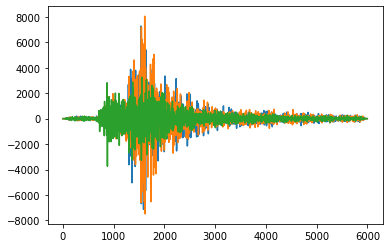

109C.TA_20070710115911_EV


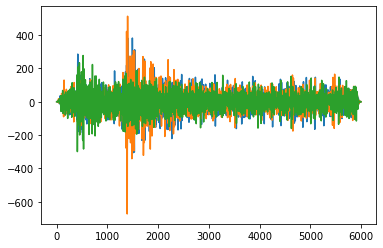

109C.TA_20070718142549_EV


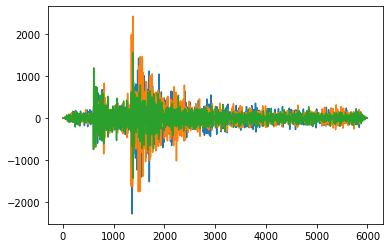

109C.TA_20070723172934_EV


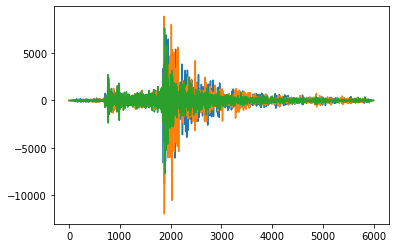

109C.TA_20070725023935_EV


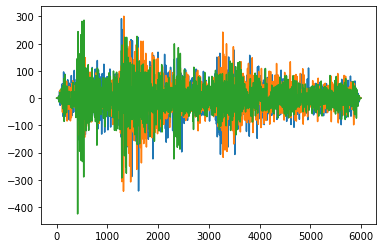

109C.TA_20070728015508_EV


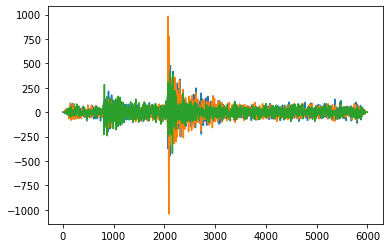

109C.TA_20070728222626_EV


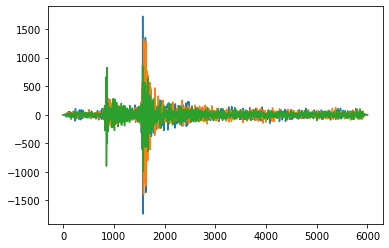

109C.TA_20070801032036_EV


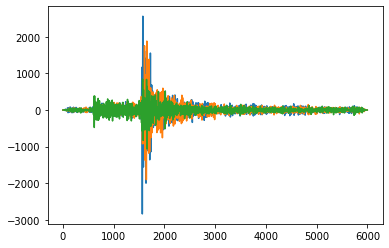

109C.TA_20070804103313_EV


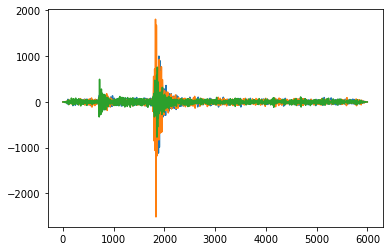

109C.TA_20070804235617_EV


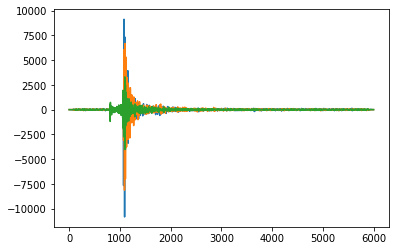

109C.TA_20070805160423_EV


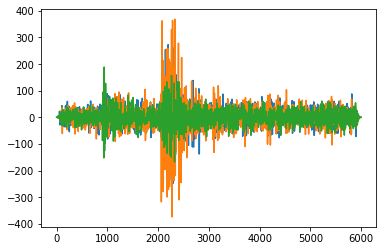

109C.TA_20070808104627_EV


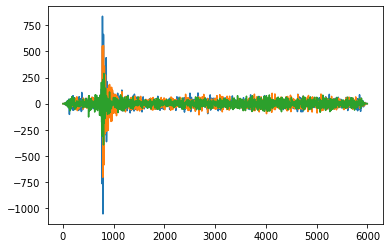

109C.TA_20070810001636_EV


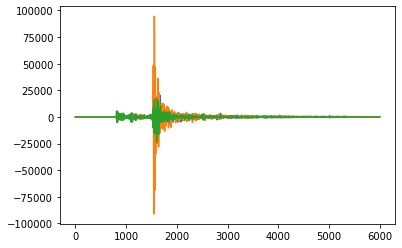

109C.TA_20070817031921_EV


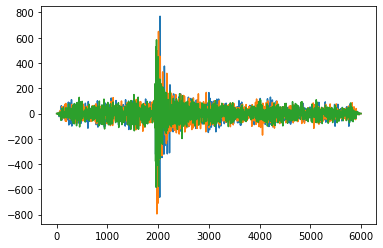

109C.TA_20070817062800_EV


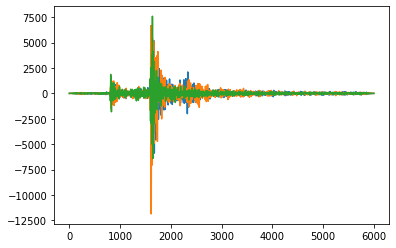

109C.TA_20070818153931_EV


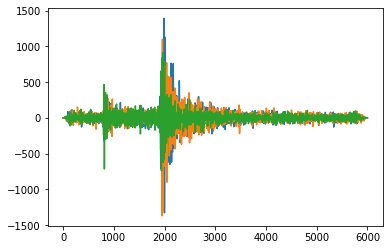

109C.TA_20070820195053_EV


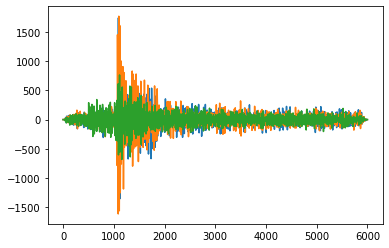

109C.TA_20070825050252_EV


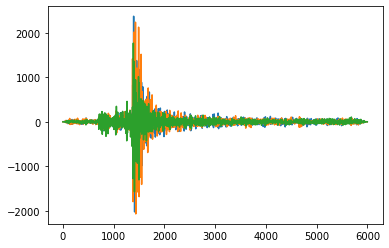

109C.TA_20070829041354_EV


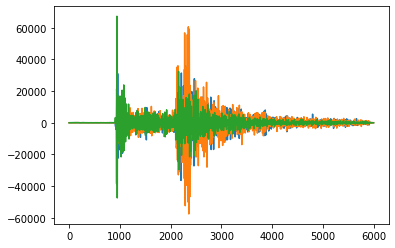

109C.TA_20070830095302_EV


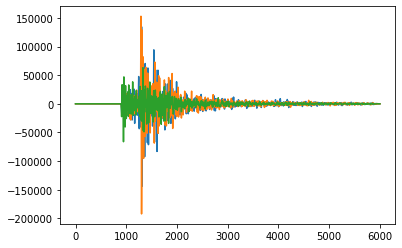

109C.TA_20070830144445_EV


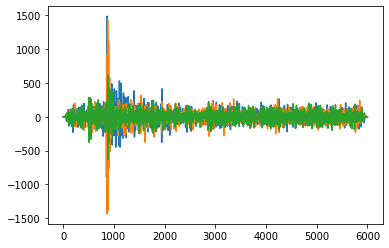

109C.TA_20070831232704_EV


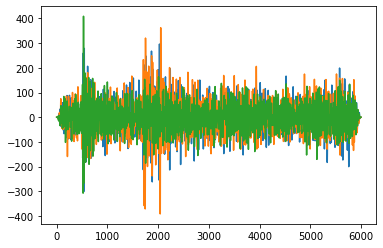

109C.TA_20070902212027_EV


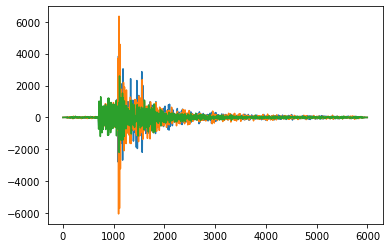

109C.TA_20070903102652_EV


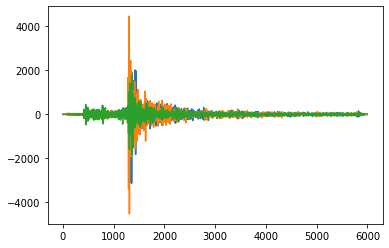

109C.TA_20070903180819_EV


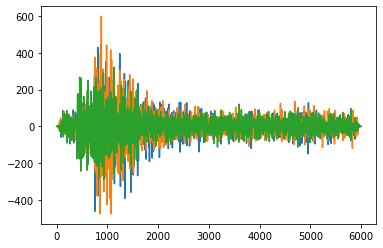

109C.TA_20070904035230_EV


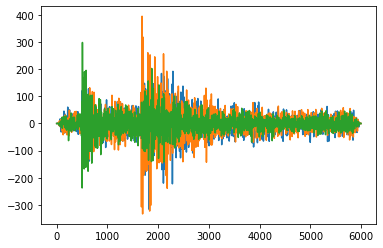

109C.TA_20070904094710_EV


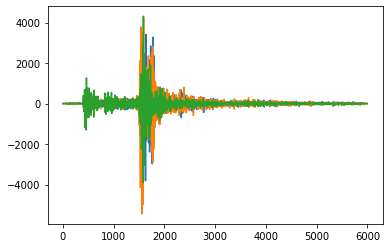

109C.TA_20070904124836_EV


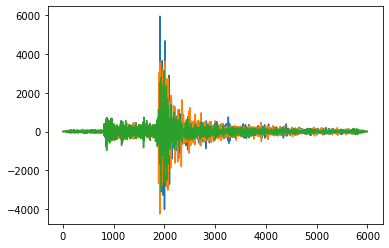

109C.TA_20070904144754_EV


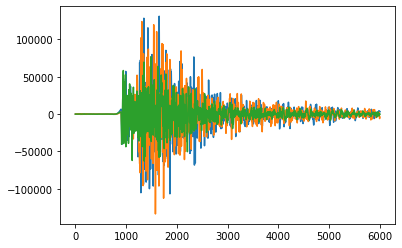

109C.TA_20070904204109_EV


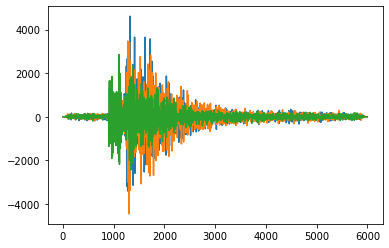

109C.TA_20070904210122_EV


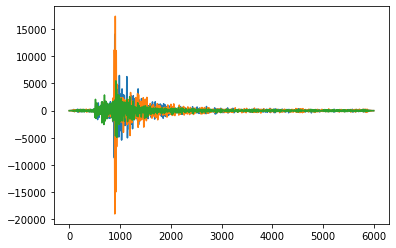

109C.TA_20070905042031_EV


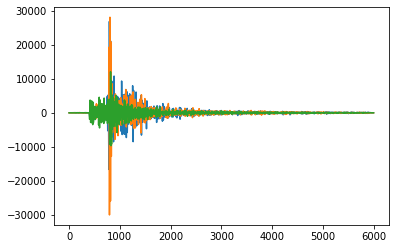

109C.TA_20070905043127_EV


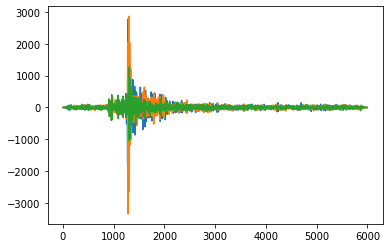

109C.TA_20070905051107_EV


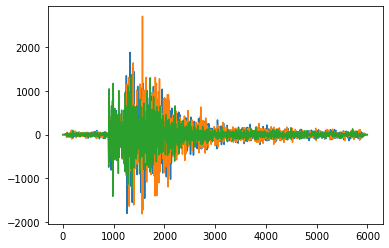

109C.TA_20070905073254_EV


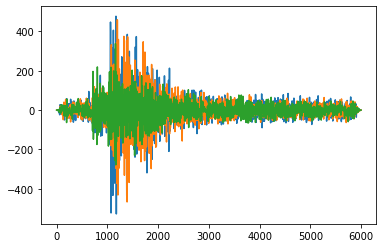

109C.TA_20070905204756_EV


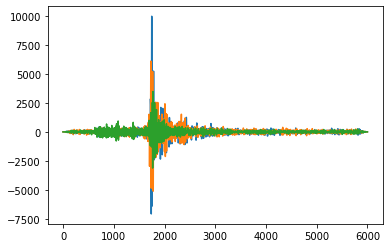

109C.TA_20070907191015_EV


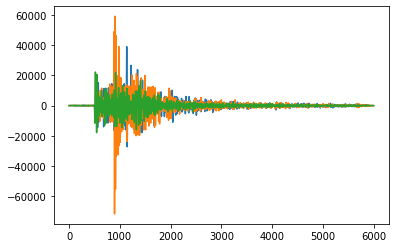

109C.TA_20070907214730_EV


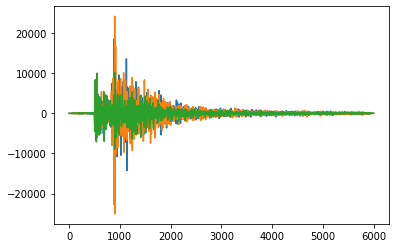

109C.TA_20070909014809_EV


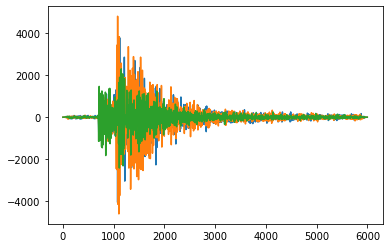

109C.TA_20070909020048_EV


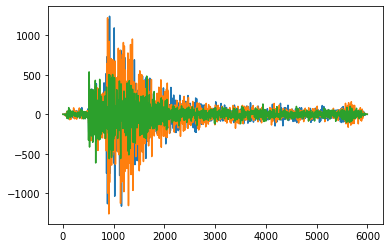

109C.TA_20070909131147_EV


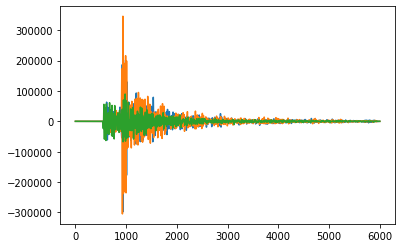

109C.TA_20070909141011_EV


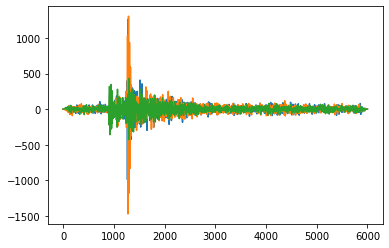

109C.TA_20070909151455_EV


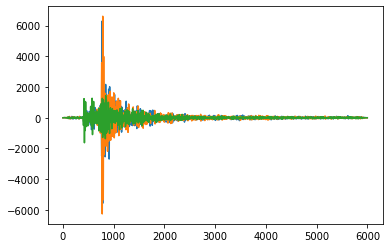

109C.TA_20070909170829_EV


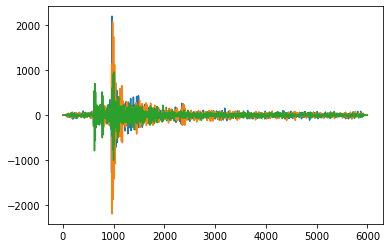

109C.TA_20070909193516_EV


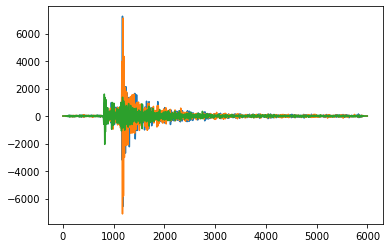

109C.TA_20070910043524_EV


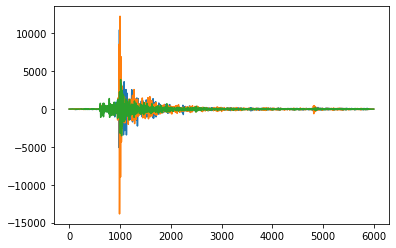

109C.TA_20070910084301_EV


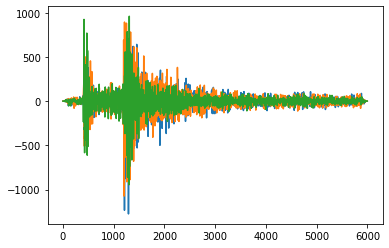

109C.TA_20070910232331_EV


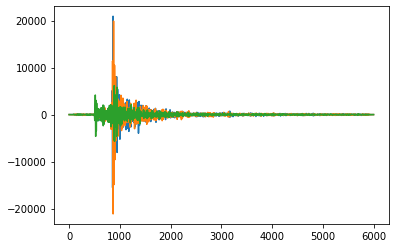

109C.TA_20070911012817_EV


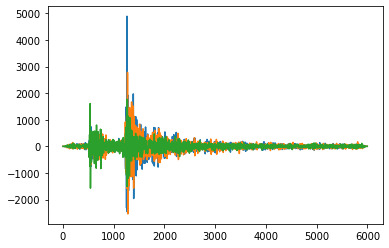

109C.TA_20070911071012_EV


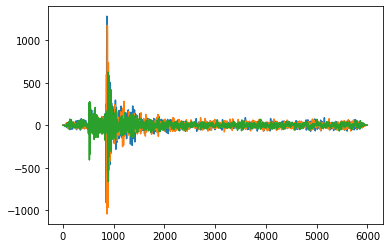

109C.TA_20070912073736_EV


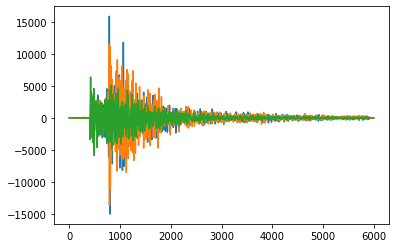

109C.TA_20070912081129_EV


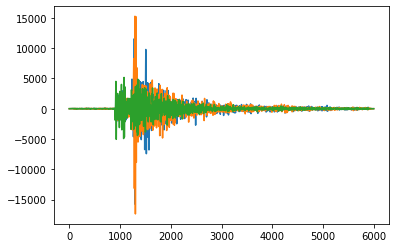

109C.TA_20070912081130_EV


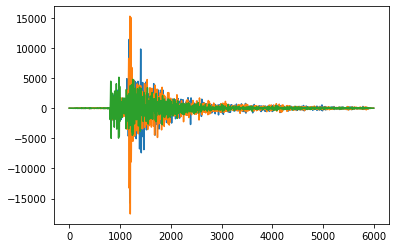

109C.TA_20070913131106_EV


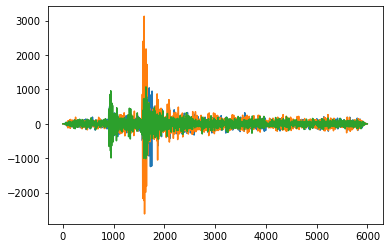

109C.TA_20070914042447_EV


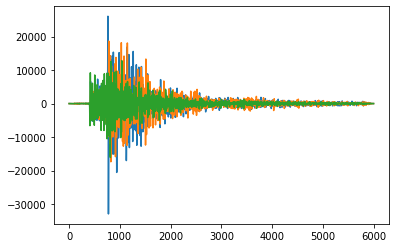

109C.TA_20070914184024_EV


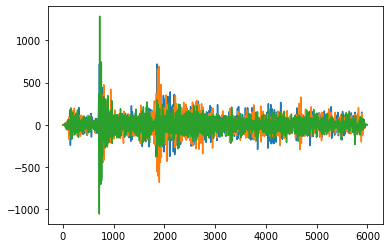

109C.TA_20070916013820_EV


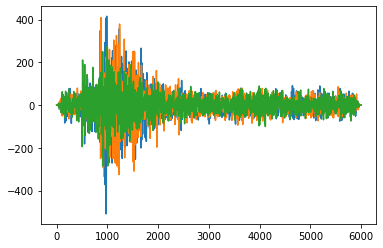

109C.TA_20070918200217_EV


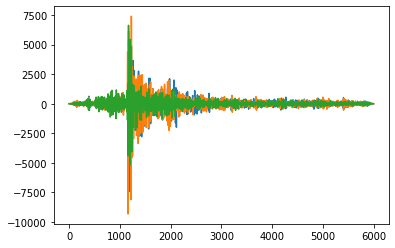

109C.TA_20070929223709_EV


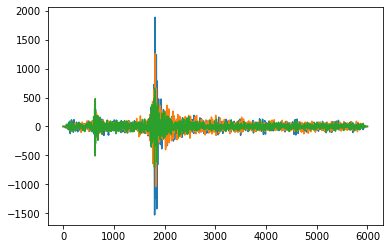

109C.TA_20070930010344_EV


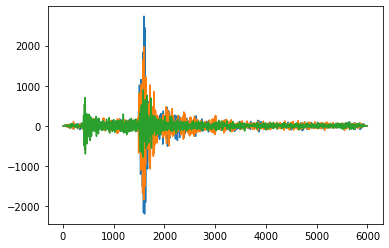

109C.TA_20070930222739_EV


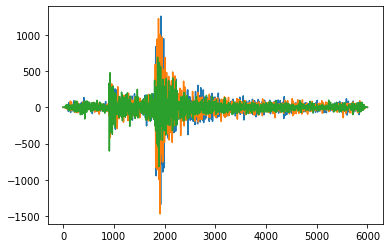

In [90]:
file_name = "EQTransformer/ModelsAndSampleData/100samples.hdf5"
csv_file = "EQTransformer/ModelsAndSampleData/100samples.csv"

# reading the csv file into a dataframe:
df = pd.read_csv(os.path.join(csv_file))
print(f'total events in csv file: {len(df)}')

# filterering the dataframe
print(f'total events selected: {len(df)}')

# making a list of trace names for the selected data
ev_list = df['trace_name'].to_numpy()
print('random choice length :', len(ev_list))

# retrieving selected waveforms from the hdf5 file: 
dtfl = h5py.File(os.path.join(file_name), 'r')

for c, evi in tqdm(enumerate(ev_list)):
    print(evi)
    dataset = dtfl.get('data/'+str(evi)) 
    
    data = np.array(dataset)
    
    plt.plot(data)
    plt.show()

In [140]:
from EQTransformer.core.mseed_predictor import _plotter_prediction
# %matplotlib inline

data_path = os.path.join(os.getcwd(), 'labeled_dump_PUSAN/dump_03.pkl')

print(data_path)

with open(os.path.join(data_path), 'rb') as f:
    data_preview = pickle.load(f)
data_preview[0]

/home/volume/workspace/Project/Earthquake/labeled_dump_PUSAN/dump_03.pkl


{'trace_start_time': datetime.datetime(2017, 11, 15, 7, 3, 30, 4000),
 'trace_end_time': datetime.datetime(2017, 11, 15, 7, 4, 30, 4000),
 'data': array([[ 33.32231546,   1.50533443, -18.17640055],
        [ 49.77137857,  -4.2081003 , -12.12052035],
        [ 60.1633187 ,  -4.57514969,  16.4734034 ],
        ..., 
        [-31.99961898,  58.38466101,  -5.67575776],
        [-35.44410396,  55.22538171,   4.78505197],
        [-39.49249525,  56.27833331, -13.40907897]]),
 'p_arv': [datetime.datetime(2017, 11, 15, 7, 3, 37, 120000)],
 's_arv': [datetime.datetime(2017, 11, 15, 7, 3, 38, 70000)],
 'p_label': 1,
 's_label': 1,
 'p_time_label': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 's_time_label': array([ 0.,  0.,  0., ...,  0.,  0.,  0.])}

In [141]:
args = {
    'plot_mode' : 'time_frequency'
}
yh1 = np.zeros(6000)

matches = {
    
}
save_figs = os.path.join(os.getcwd(), 'save_fig_test')
for idx in tqdm(range(len(data_preview))):
    _plotter_prediction(data_preview[idx]['data'], args, save_figs, 
                        yh1, data_preview[idx]['p_time_label'], data_preview[idx]['s_time_label'], 
                        data_preview[idx]['trace_start_time'], matches)

<Figure size 720x720 with 0 Axes>